---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
---

![](../../assets/mag.png){width=75px align="left"}

# Introduction

This analysis explores patterns and trends in the death penalty across the United States, examining how the death penalty is applied across different jurisdictions, demographics, and time periods. 

Key areas of investigation include:
- Current death penalty status by state and abolition patterns
- Geographic distribution of death sentences at the county level
- Racial and demographic patterns in sentencing
- Analysis of upcoming scheduled executions
- Public opinion data on capital punishment
- Outcomes of death penalty cases including exonerations
- Victim characteristics in capital cases

By examining these different facets of the death penalty system, we can uncover meaningful patterns and potential disparities in how the death penalty is applied. Special attention is paid to geographic concentration and racial distributions.

# Code

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from matplotlib import colors as mcolors

### States with/without the Death Penalty

To begin our analysis, it is important to know which states still have the death penalty.

In [2]:
death_penalty_df = pd.read_csv("../../data/processed-data/has_death_penalty_cleaned.csv")
death_penalty_df.head()

,state,has_death_penalty,abolished
0,Alabama,1,NaN
1,Alaska,0,1957.0
2,Arizona,1,NaN
3,Arkansas,1,NaN
4,California,1,NaN



Value Counts:
has_death_penalty
1    27
0    23
Name: count, dtype: int64


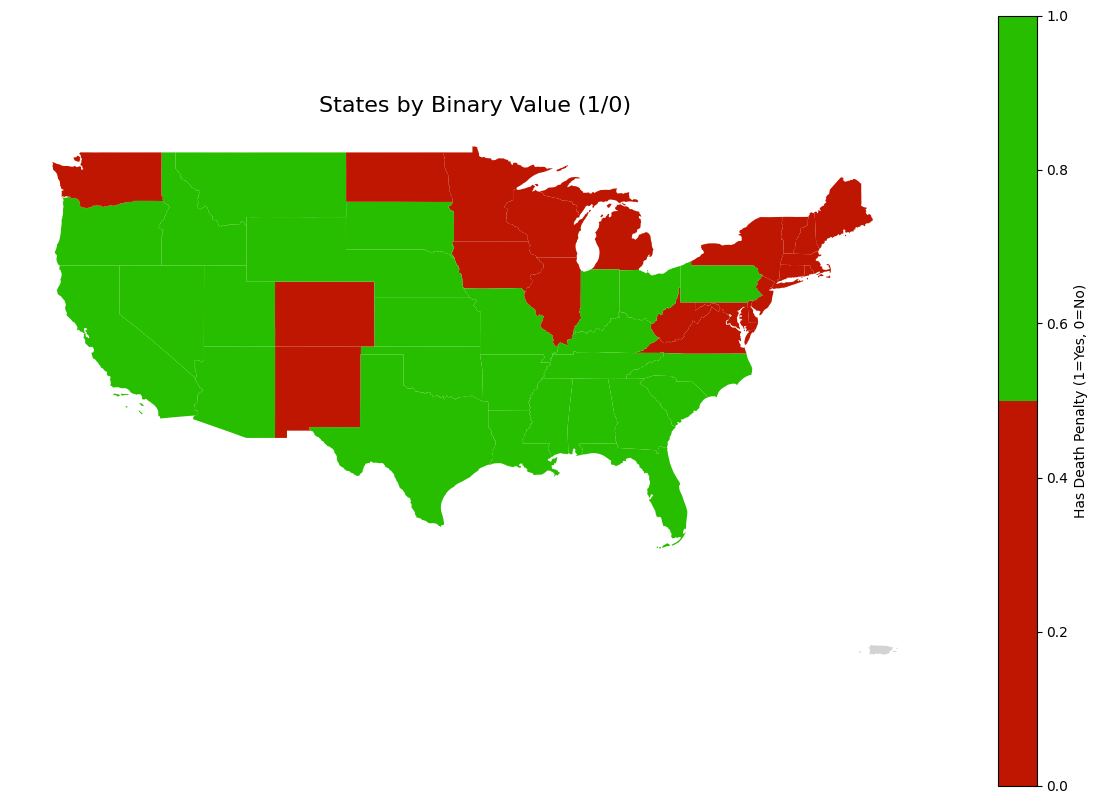

In [3]:
states_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"
states = gpd.read_file(states_url)

states = states[~states['STUSPS'].isin(['AK', 'HI'])]

merged = states.merge(death_penalty_df, 
                     left_on='NAME',  
                     right_on='state', 
                     how='left')

colors = ['#be1600', '#27be00']  
cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(15, 10))
merged.plot(column='has_death_penalty',
           ax=ax,
           legend=True,
           legend_kwds={'label': 'Has Death Penalty (1=Yes, 0=No)'},
           missing_kwds={'color': 'lightgrey'},
           cmap=cmap)

plt.title('States by Binary Value (1/0)', fontsize=16)
ax.axis('off')

print("\nValue Counts:")
print(death_penalty_df['has_death_penalty'].value_counts())

27 states currently have the death penalty, and 23 states have abolished it.

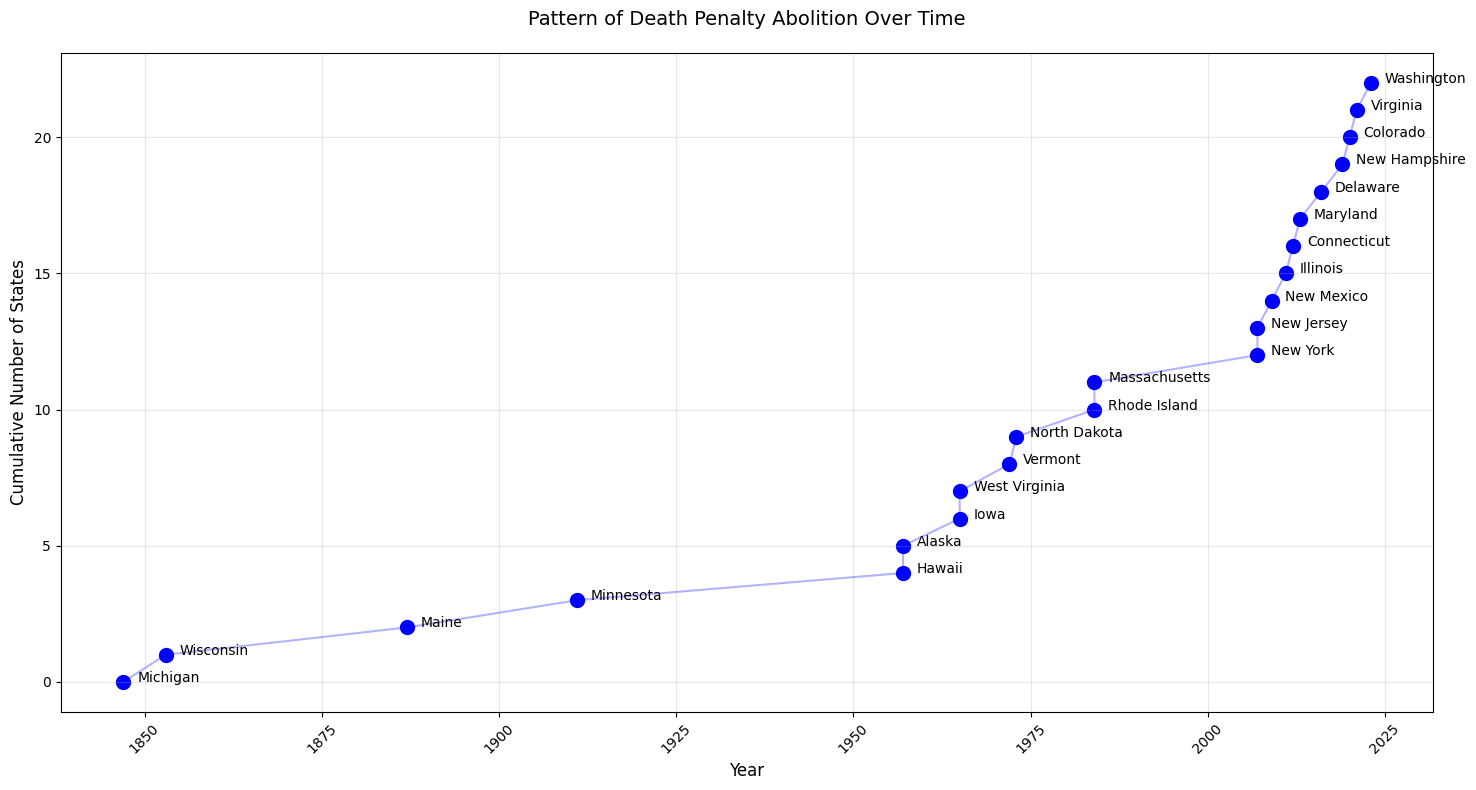

In [4]:
death_penalty_df.loc[death_penalty_df['state'] == 'West Virginia', 'abolished'] = 1965

abolished_states = death_penalty_df[death_penalty_df['abolished'].notna()].copy()
abolished_states = abolished_states.sort_values('abolished')

plt.figure(figsize=(15, 8))

plt.plot(abolished_states['abolished'], range(len(abolished_states)), 
         'b-', alpha=0.3)
plt.scatter(abolished_states['abolished'], range(len(abolished_states)), 
           c='blue', s=100)

for i, row in abolished_states.iterrows():
    plt.annotate(row['state'], 
                (row['abolished'], abolished_states.index.get_loc(i)),
                xytext=(10, 0), textcoords='offset points')

plt.title('Pattern of Death Penalty Abolition Over Time', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Number of States', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Michigan, Wisconsin, Maine, and Minnesota were significantly ahead of the curve in abolishing the death penalty. Two notable gaps emerged in the timeline, one of them beginning with Alaska and Hawaii in the 1950s, and then another pause after Massachussets, and then another wave began in the 2000's.

The trend seems to suggest that eventually more and more states will abolish the death penalty.

### Upcoming Executions

In [5]:
upcoming_executions_df = pd.read_csv("../../data/processed-data/all_scheduled_executions.csv")

In [6]:
upcoming_executions_df['Year'] = pd.to_numeric(upcoming_executions_df['Year'], errors='coerce')  
upcoming_executions_df = upcoming_executions_df.dropna(subset=['Year'])  
upcoming_executions_df['Year'] = upcoming_executions_df['Year'].astype(int)  

In [ ]:
upcoming_executions_df.head()

Dataset shape: (31, 4)
Columns in the dataset: Index(['Date', 'State', 'Prisoner', 'Year'], dtype='object')
Preview of the dataset:
          Date State                    Prisoner  Year
0  November 21    AL          Carey Dale Grayson  2024
1   December 3    MO  Christopher Leroy Collings  2024
2  December 18    IN             Joseph Corcoran  2024
3  December 19    OK         Kevin Ray Underwood  2024
4   February 5    TX               Steven Nelson  2025


We have Date, State, Prisoner, and Year in this dataset. We are interested in year and state.

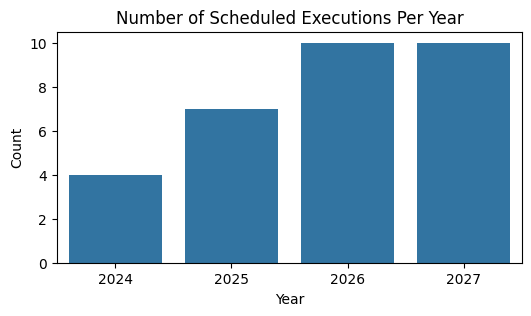

In [ ]:
sns.countplot(data=upcoming_executions_df, x='Year', order=sorted(upcoming_executions_df['Year'].unique()))
plt.title("Number of Scheduled Executions Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Executions increase steadily from 2024 to 2027.

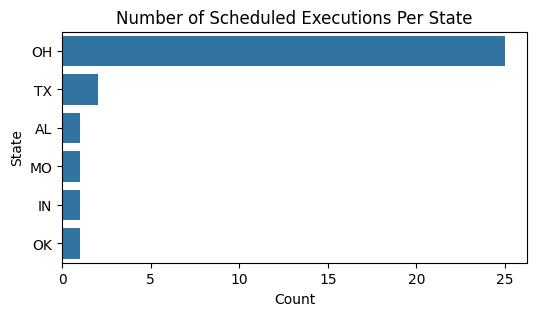

In [9]:
plt.figure(figsize=(6, 3))

state_order = upcoming_executions_df['State'].value_counts().index
sns.countplot(data=upcoming_executions_df, y='State', order=state_order)
plt.title("Number of Scheduled Executions Per State")
plt.xlabel("Count")
plt.ylabel("State")
plt.show()

Oklahoma has a disproportionate amount of executions scheduled.

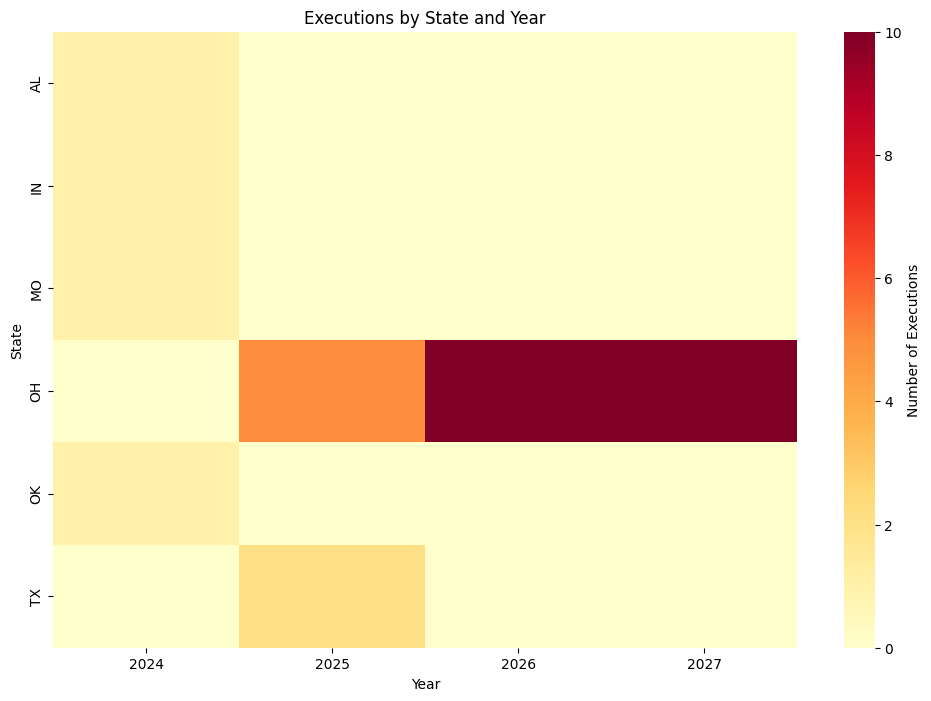

In [10]:
heatmap_data = pd.crosstab(upcoming_executions_df['State'], upcoming_executions_df['Year'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Number of Executions'})
plt.title('Executions by State and Year')
plt.show()

Ohio has 0 executions scheduled in 2024, but they are the only state with executions scheduled in 2026 and 2027. Not only do they have executions scheduled, but there are a lot of them (approximately 8-10 a year). Texas only has a few executions scheduled in 2025, and all the other states have a few scheduled in 2024.

We have now looked at our first dataset, upcoming executions. This gave us a feel for the executions that will occur in the next 3 years. 

### Public Opinion on the Death Penalty in 2002

A major factor in keeping the death penalty around or not is public opinion. Although the dataset is a little outdated, let's see if we can draw any insights about the groups of people who favor the death penalty.

In [11]:
public_belief_df = pd.read_csv("../../data/processed-data/death_penalty_beliefs_cleaned.csv")

In [12]:
normalized_party_df = (public_belief_df.groupby(['polparty', 'deathpenalty'])
                     .size()
                     .unstack(fill_value=0))

normalized_party_df = (normalized_party_df.div(normalized_party_df.sum(axis=1), axis=0) * 100)

It is important to normalize the data, because the dataset contains an unequal representation of political parties.

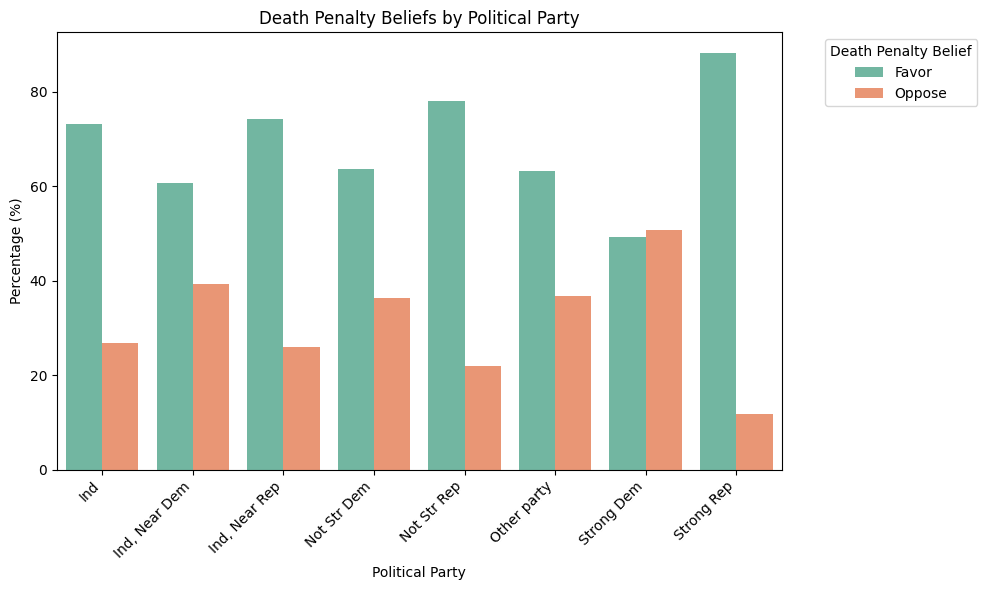

In [13]:
plot_df = normalized_party_df.reset_index().melt(
   id_vars=['polparty'],
   var_name='deathpenalty',
   value_name='percentage'
)

plt.figure(figsize=(10, 6))
sns.barplot(
   data=plot_df,
   x='polparty',
   y='percentage',
   hue='deathpenalty',
   palette='Set2'
)

plt.title("Death Penalty Beliefs by Political Party")
plt.xlabel("Political Party")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Death Penalty Belief", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The only political party in the dataset that opposes the death penalty are strong Democrats, but only by a very slim margin. Almost every political party seems to strongly favor the death penalty. 

In [14]:
normalized_religion_df = (public_belief_df.groupby(['religion', 'deathpenalty'])
                        .size()
                        .unstack(fill_value=0))

normalized_religion_df = (normalized_religion_df.div(normalized_religion_df.sum(axis=1), axis=0) * 100)

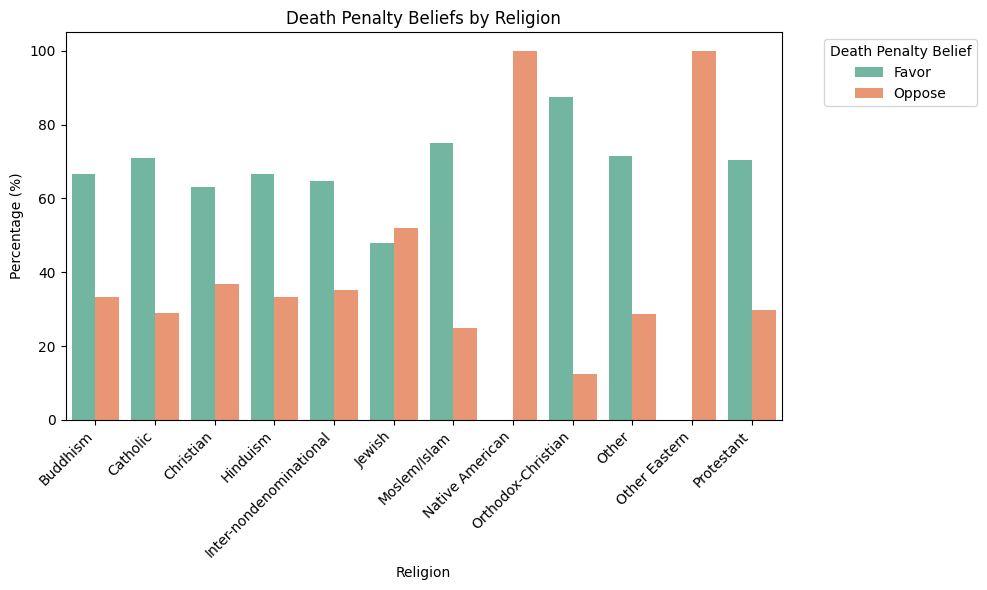

In [15]:
plot_df = normalized_religion_df.reset_index().melt(
    id_vars=['religion'],
    var_name='deathpenalty',
    value_name='percentage'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='religion',
    y='percentage',
    hue='deathpenalty',
    palette='Set2'
)

plt.title("Death Penalty Beliefs by Religion")
plt.xlabel("Religion")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Death Penalty Belief", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

All Native Americans and other Easterners in this dataset oppose the death penalty. All other religions support the death penalty at much higher rates than they oppose it except for Jewish people, who only support it by a small margin.

In [16]:
normalized_gender_df = (public_belief_df.groupby(['gender', 'deathpenalty'])
                       .size()
                       .unstack(fill_value=0))

normalized_gender_df = (normalized_gender_df.div(normalized_gender_df.sum(axis=1), axis=0) * 100)

plot_df = normalized_gender_df.reset_index().melt(
   id_vars=['gender'],
   var_name='deathpenalty',
   value_name='percentage'
)

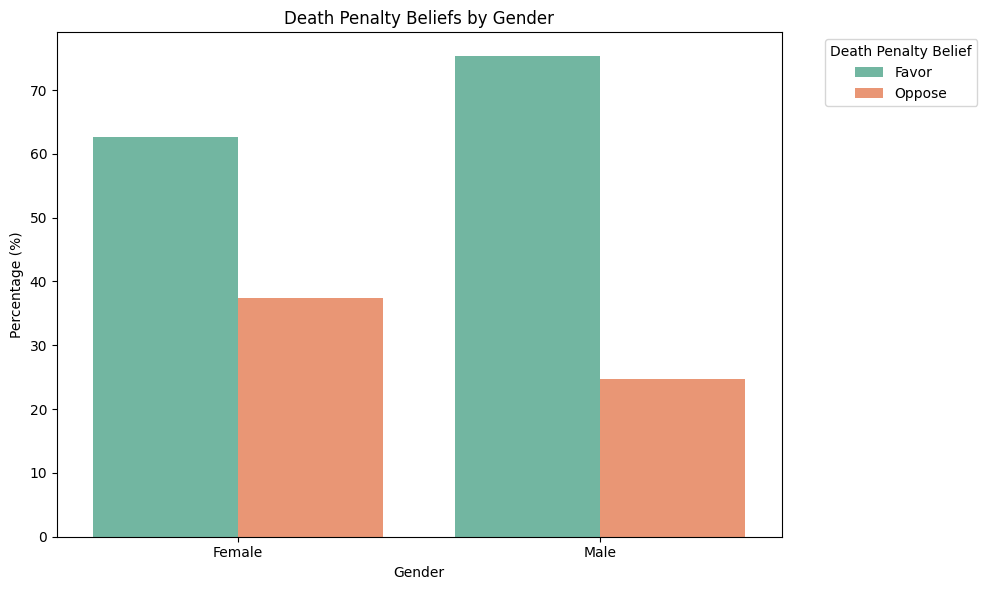

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(
   data=plot_df,
   x='gender', 
   y='percentage',
   hue='deathpenalty',
   palette='Set2'
)

plt.title("Death Penalty Beliefs by Gender")
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)  # No need to rotate with just M/F
plt.legend(title="Death Penalty Belief", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Males and females both overwhelmingly support the death penalty, but males support it slightly more than females.

In [18]:
normalized_race_df = (public_belief_df.groupby(['race', 'deathpenalty'])
                       .size()
                       .unstack(fill_value=0))

normalized_race_df = (normalized_race_df.div(normalized_race_df.sum(axis=1), axis=0) * 100)

plot_df = normalized_race_df.reset_index().melt(
   id_vars=['race'],
   var_name='deathpenalty',
   value_name='percentage'
)

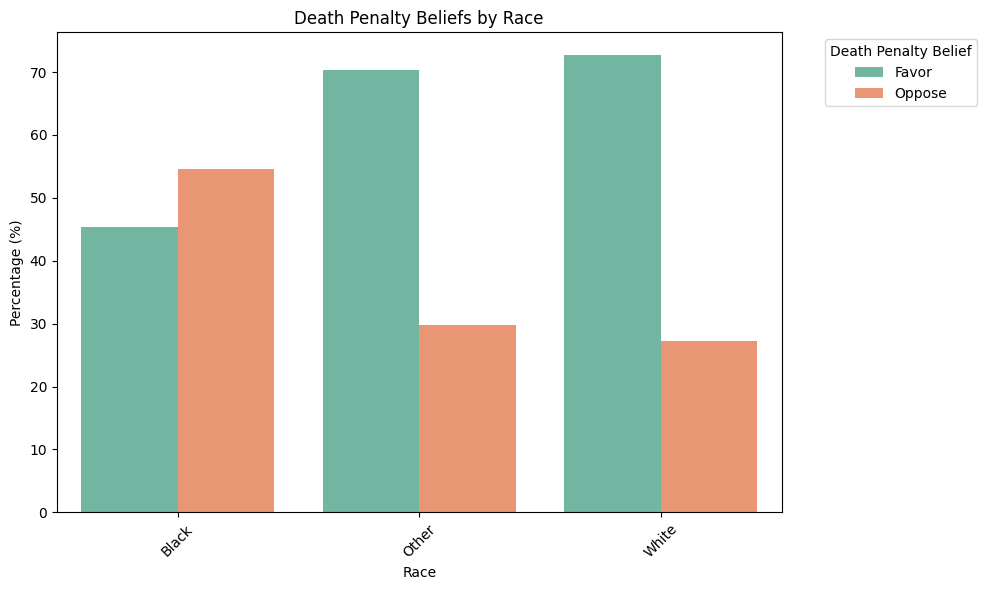

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(
   data=plot_df,
   x='race', 
   y='percentage',
   hue='deathpenalty',
   palette='Set2'
)

plt.title("Death Penalty Beliefs by Race")
plt.xlabel("Race")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="Death Penalty Belief", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

White and "other" races overwhelmingly support the death penalty, while back people oppose it by a slim margin.

This dataset, although outdated, showed us that there are not necessarily certain groups of people who support or oppose the death penalty. Almost all groups looked at favored the death penalty, except Native Americans, some Easteners, black people, and strong Democrats. Even the groups that did oppose it were by very slim margins. 2002 was before 11 states abolished the death penalty, which we learned in the above EDA.

### Sentence Outcomes Nationally

Let's look at how many lives the death penalty has currently taken, along with other outcomes in the United States.

In [20]:
sentence_outcomes_df = pd.read_csv("../../data/processed-data/sentence_outcomes_nationally.csv")
sentence_outcomes_df.head()

,all reversals,"4,732"
0,on death row,"2,272"
1,executed,"1,542"
2,"died, not executed",734
3,commutation,291
4,exoneration,183


In [21]:
print("\nSummary Statistics:")
print(sentence_outcomes_df.describe(include='all').transpose())


Summary Statistics:
              count unique           top freq
all reversals     7      7  on death row    1
4,732             7      7         2,272    1


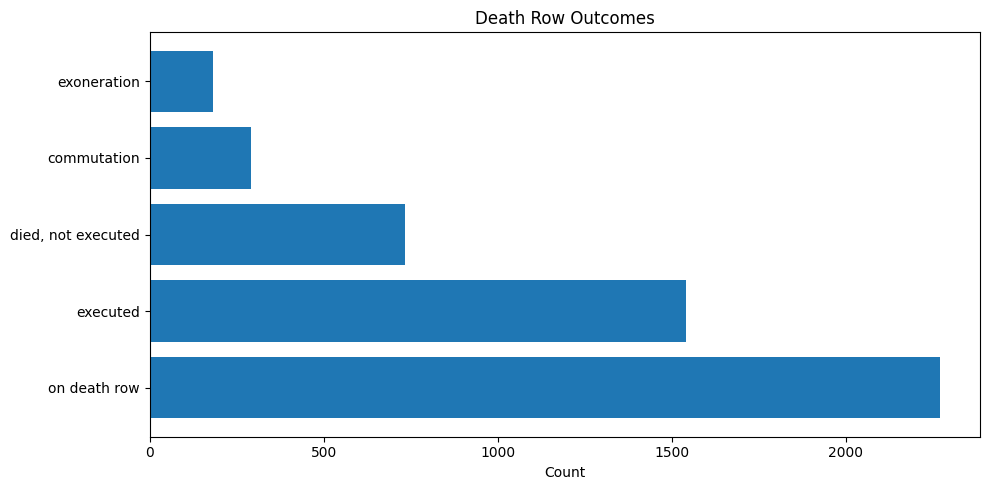

In [22]:
data = {
    'outcome': ['on death row', 'executed', 'died, not executed', 'commutation', 'exoneration'],
    'count': [2272, 1542, 734, 291, 183]
}
sentence_outcomes_df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
plt.barh(sentence_outcomes_df['outcome'], sentence_outcomes_df['count'])

plt.xlabel('Count')
plt.title('Death Row Outcomes')
plt.tight_layout()

This is interesting, because before we only saw around 30 executions have been scheduled. Here, we can see that despite having fewer executions scheduled, over 2,000 people remain on death row. 1,542 peple have died from execution and 734 people have died waiting for execution. 291 people got commutation, meaning their sentence was reduced from death, and 183 people were exonerated. 

Exoneration is a very important aspect of the death penalty and its past in the United States. Let's look at some datasets from the Innocence Project - which is an organization dedicated to exonerating wrongfully convicted criminals or those given unfair trials. 

### Innocence Project Death Row Exonerees

In [23]:
death_exon = pd.read_csv("../../data/processed-data/innocence-project-death-penalty-cases_cleaned.csv")
death_exon.head()

,name,time_served,state,charge,conviction,sentence,accused_pleaded_guilty,contributing_causes_of_conviction,death_penalty_case,race_of_exoneree,...,residential_burglary,robbery.1,sexual_assault.1,sexual_battery.1,eyewitness_misidentification,false_confessions_or_admissions,government_misconduct,inadequate_defense,informants,unvalidated_or_improper_forensic_science
0,Clemente Aguirre-Jarquin,NaN,Florida,"Murder, Burglary","First-degree Murder, Burglary",Death,0,Unvalidated or Improper Forensic Science,1,Latinx,...,0,0,0,0,0,0,0,0,0,1
1,Kirk Bloodsworth,8.0,Maryland,"Murder, Sexual Assault, Rape","First-degree Murder, Sexual Assault, Rape",Death,0,"Eyewitness Misidentification, Government Misco...",1,Caucasian,...,0,0,1,0,1,0,1,0,0,0
2,Kennedy Brewer,15.0,Mississippi,"Capital Murder, Sexual Battery","Capital Murder, Sexual Battery",Death,0,"Government Misconduct, Unvalidated or Improper...",1,African American,...,0,0,0,1,0,0,1,0,0,1
3,Rolando Cruz,10.0,Illinois,"Rape, Murder, Kidnapping, Home Invasion","Murder, Rape, Aggravated Kidnapping (2 cts.), ...",Death,0,"False Confessions or Admissions, Government Mi...",1,Latinx,...,1,0,0,0,0,1,1,0,1,1
4,Michael Blair,14.0,Texas,Capital Murder,Capital Murder,Death,0,"Eyewitness Misidentification, Unvalidated or I...",1,Asian American,...,0,0,0,0,1,0,0,0,0,1


In [24]:
num_rows = death_exon['name'].count()
print(f"Number of rows: {num_rows}")

Number of rows: 20


Innocence Project has exonerated 20 death row cases.

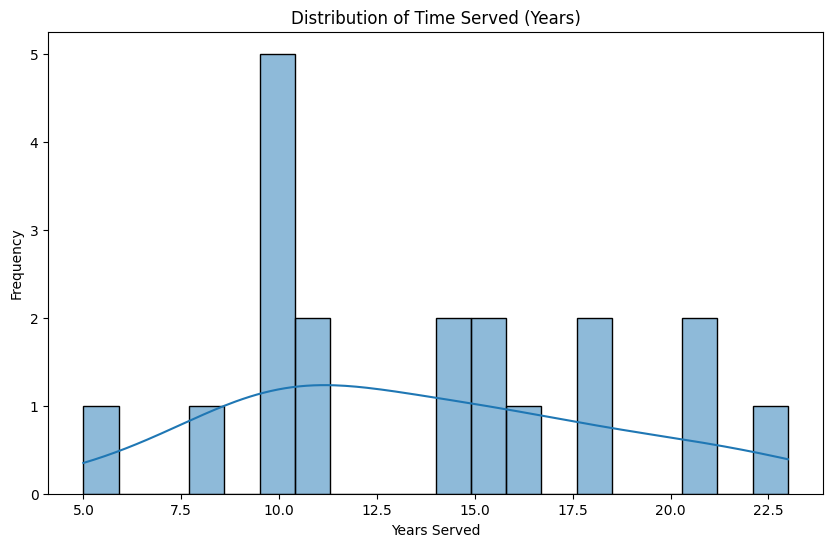

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(death_exon['time_served'], bins=20, kde=True)
plt.title('Distribution of Time Served (Years)')
plt.xlabel('Years Served')
plt.ylabel('Frequency')
plt.show()

The data ranges from about 5 years to 22.5 years served. The most common length of time served is around 10 years, with 5 cases falling in this range. The blue curve overlaid on the histogram suggests a roughly normal distribution with a slight right skew, peaking around 11-12 years. 

/var/folders/gf/ppk7yck96gx15bzg93b7fysm0000gn/T/ipykernel_46565/1870921239.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='race_of_exoneree', data=death_exon,


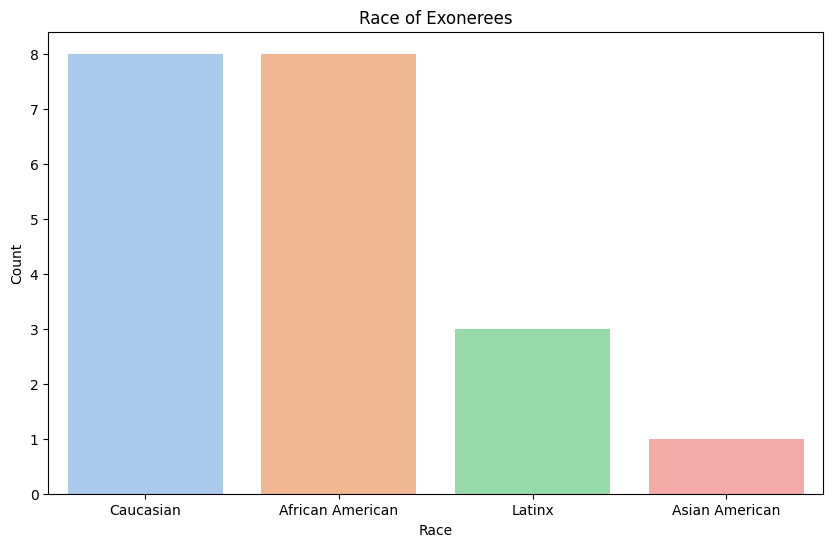

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='race_of_exoneree', data=death_exon, 
              order=death_exon['race_of_exoneree'].value_counts().index, palette="pastel")
plt.title('Race of Exonerees')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

Caucasians and African Americans are the two most frequently exonerated races by the Innocence Project, likely reflecting their status as the most frequently sentenced groups.

Text(0.5, 0, 'Count')

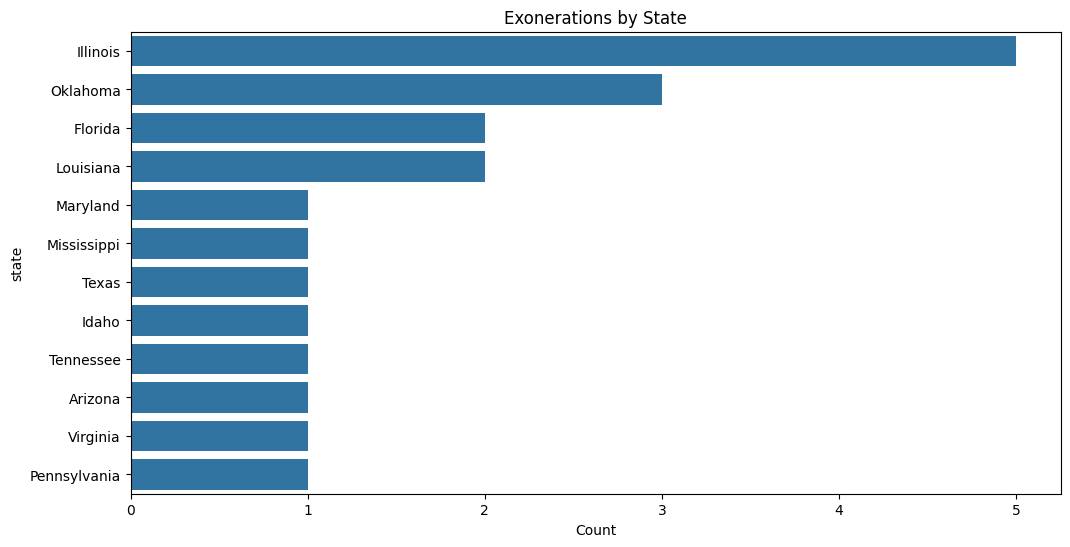

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(y='state', data=death_exon, order=death_exon['state'].value_counts().index)
plt.title('Exonerations by State')
plt.xlabel('Count')

Innocence Project has had the most death row exonerations in Illinois, followed by Oklahoma, Florida, and Louisiana. This may indicate a higher prevalence of flawed trials or misconduct in these states. To confirm this trend, we should look at the number of exonerations by the Innocence Project across all cases.

/var/folders/gf/ppk7yck96gx15bzg93b7fysm0000gn/T/ipykernel_46565/1284730877.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=charge_counts.values, y=charge_counts.index, palette='rocket')


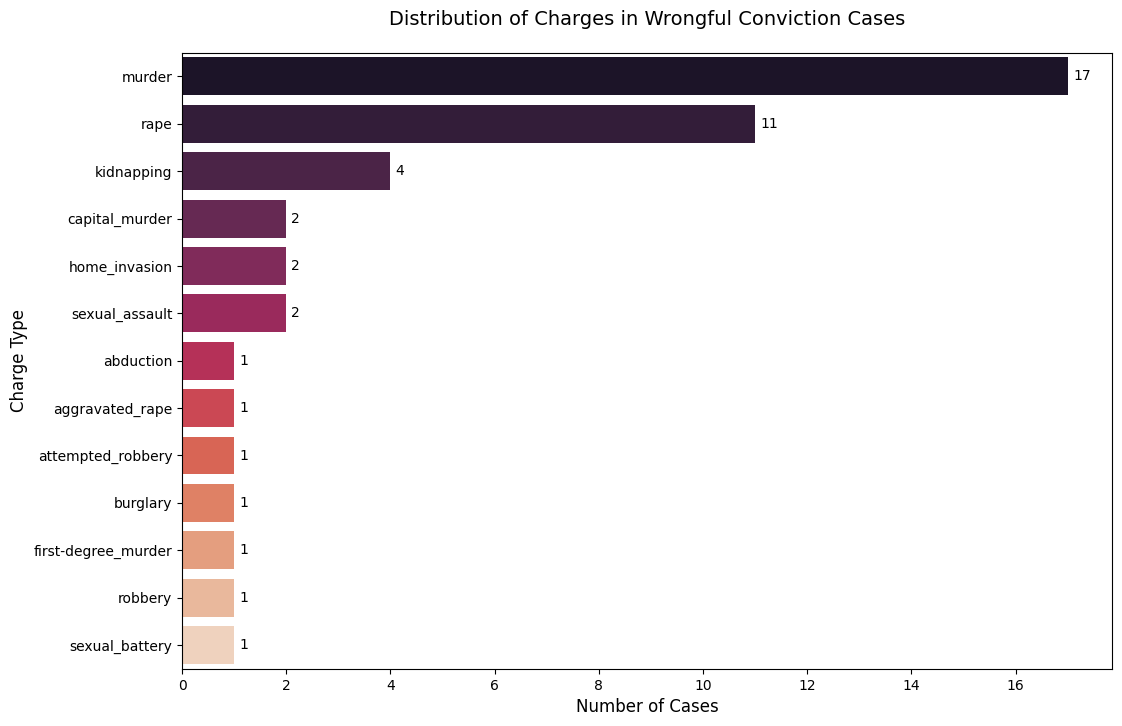

In [28]:
charge_columns = ['abduction', 'aggravated_rape', 'attempted_robbery', 
                 'burglary', 'capital_murder', 'first-degree_murder',
                 'home_invasion', 'kidnapping', 'murder', 'rape',
                 'robbery', 'sexual_assault', 'sexual_battery']

charge_counts = death_exon[charge_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=charge_counts.values, y=charge_counts.index, palette='rocket')
plt.title('Distribution of Charges in Wrongful Conviction Cases', pad=20, fontsize=14)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Charge Type', fontsize=12)

for i, v in enumerate(charge_counts.values):
    plt.text(v + 0.1, i, str(int(v)), va='center')

### Innocence Project Death Row Exonerees

In [64]:
all_exon = pd.read_csv("../../data/processed-data/innocence-project-all-cases_cleaned.csv")
all_exon.head()

,name,time_served,state,charge,conviction,sentence,accused_pleaded_guilty,contributing_causes_of_conviction,death_penalty_case,race_of_exoneree,...,Use of a Firearm,Vehicle Theft,Wrongful Imprisonment,in concert),Eyewitness Misidentification,False Confessions or Admissions,Government Misconduct,Inadequate Defense,Informants,Unvalidated or Improper Forensic Science
0,A.B. Butler,17.0,Texas,"Rape, Kidnapping",Aggravated Kidnapping (rape was aggravating fa...,99 years,0,Eyewitness Misidentification,0,African American,...,0,0,0,0,1,0,0,0,0,0
1,Alan Newton,21.0,New York,"Rape, Robbery, Assault","Rape, Robbery, Assault",13 1/3 to 40 years,0,Eyewitness Misidentification,0,African American,...,0,0,0,0,1,0,0,0,0,0
2,Albert Johnson,10.0,California,Sexual Assault,Sexual Assault (2 cts.),39 years,0,"Eyewitness Misidentification, Government Misco...",0,African American,...,0,0,0,0,1,0,1,0,0,0
3,Alejandro Hernandez,10.0,Illinois,"Murder, Rape, Kidnapping, Home Invasion, etc.","Murder, Rape, Aggravated Kidnapping, Deviant S...",Death,0,"False Confessions or Admissions, Government Mi...",1,Latinx,...,0,0,0,0,0,1,1,0,0,1
4,Andre Hatchett,25.0,New York,Second-degree Murder,Second-degree Murder,25 years to life,0,"Eyewitness Misidentification, Government Misco...",0,African American,...,0,0,0,0,1,0,1,1,0,0


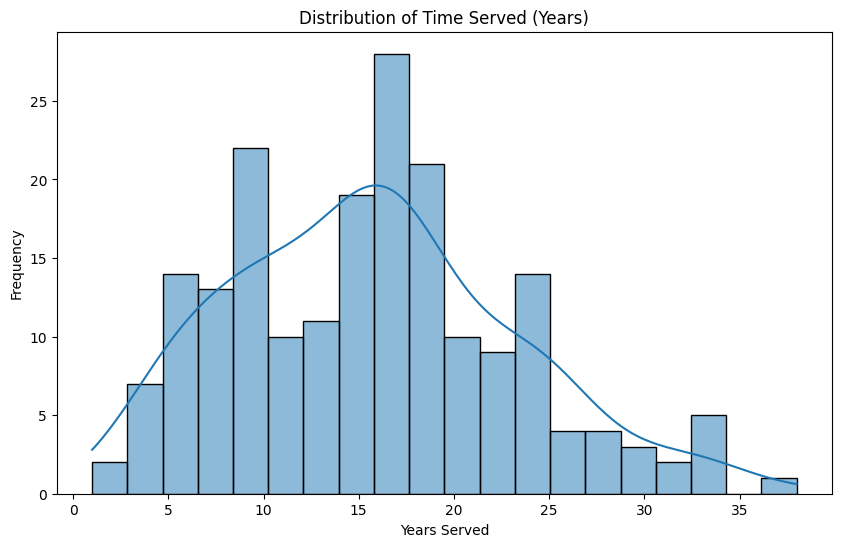

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(all_exon['time_served'], bins=20, kde=True)
plt.title('Distribution of Time Served (Years)')
plt.xlabel('Years Served')
plt.ylabel('Frequency')
plt.show()

The distribution of time served before exoneration shows that most individuals served between 10 and 20 years, with the peak around 15 years. The tail of the distribution extends beyond 30 years, indicating that a few individuals served significantly longer sentences before being exonerated.

/var/folders/gf/ppk7yck96gx15bzg93b7fysm0000gn/T/ipykernel_46565/3911810132.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='race_of_exoneree', data=all_exon,


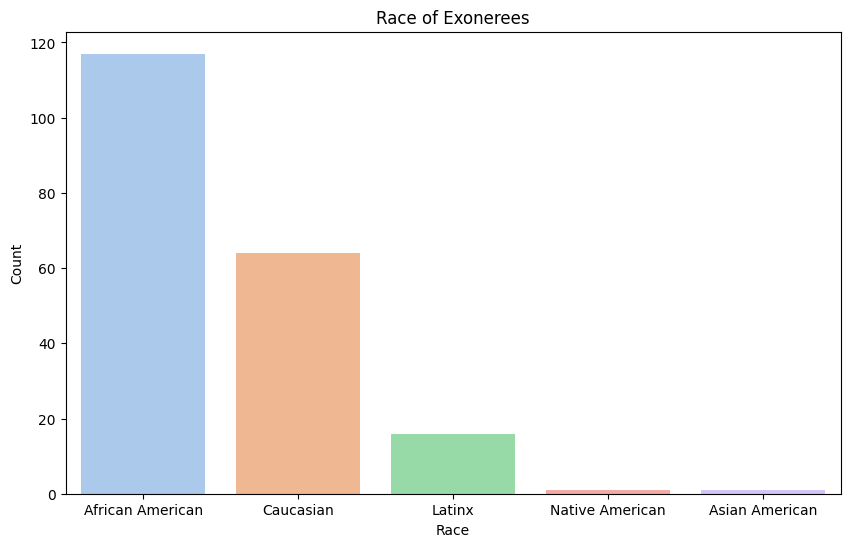

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(x='race_of_exoneree', data=all_exon, 
              order=all_exon['race_of_exoneree'].value_counts().index, palette="pastel")
plt.title('Race of Exonerees')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

Among all exonerees of the Innocence Project, African Americans represent the majority, contrasting with death row cases where African Americans and Caucasians had an equal number of exonerations. New York and Texas are now the highest.

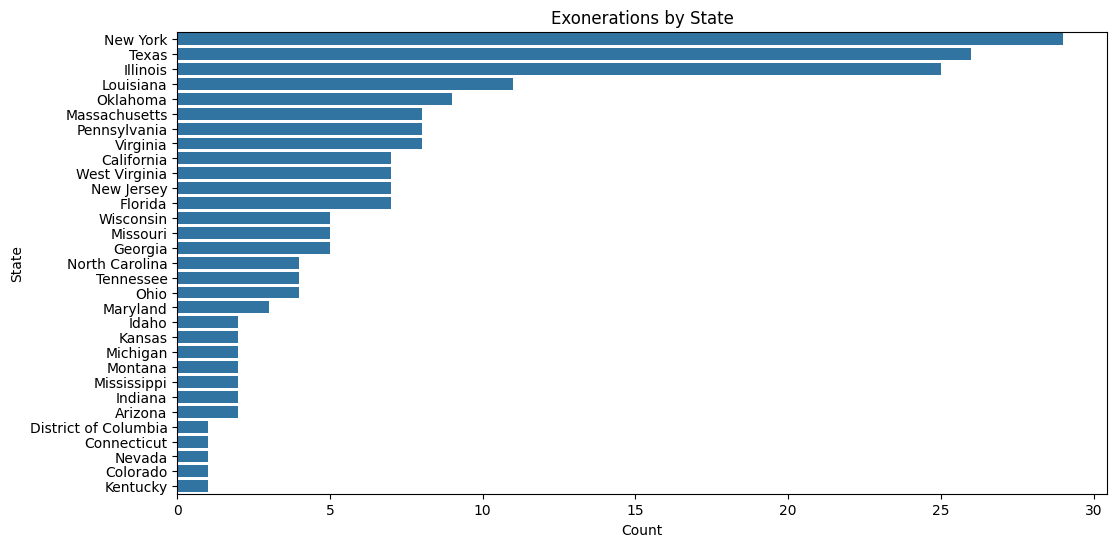

In [67]:
plt.figure(figsize=(12, 6))
sns.countplot(y='state', data=all_exon, order=all_exon['state'].value_counts().index)
plt.title('Exonerations by State')
plt.xlabel('Count')
plt.ylabel('State')
plt.show()

Illinois, Oklahoma, and Louisiana continue to have high exoneration rates; however, their numbers are now surpassed by states like New York and Texas in overall exonerations.

In [68]:
print(all_exon.columns)

Index(['name', 'time_served', 'state', 'charge', 'conviction', 'sentence',
       'accused_pleaded_guilty', 'contributing_causes_of_conviction',
       'death_penalty_case', 'race_of_exoneree',
       ...
       'Use of a Firearm', 'Vehicle Theft', 'Wrongful Imprisonment',
       'in concert)', 'Eyewitness Misidentification',
       'False Confessions or Admissions', 'Government Misconduct',
       'Inadequate Defense', 'Informants',
       'Unvalidated or Improper Forensic Science'],
      dtype='object', length=146)


/var/folders/gf/ppk7yck96gx15bzg93b7fysm0000gn/T/ipykernel_46565/342602851.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_charges.values, y=top_20_charges.index, palette='rocket')


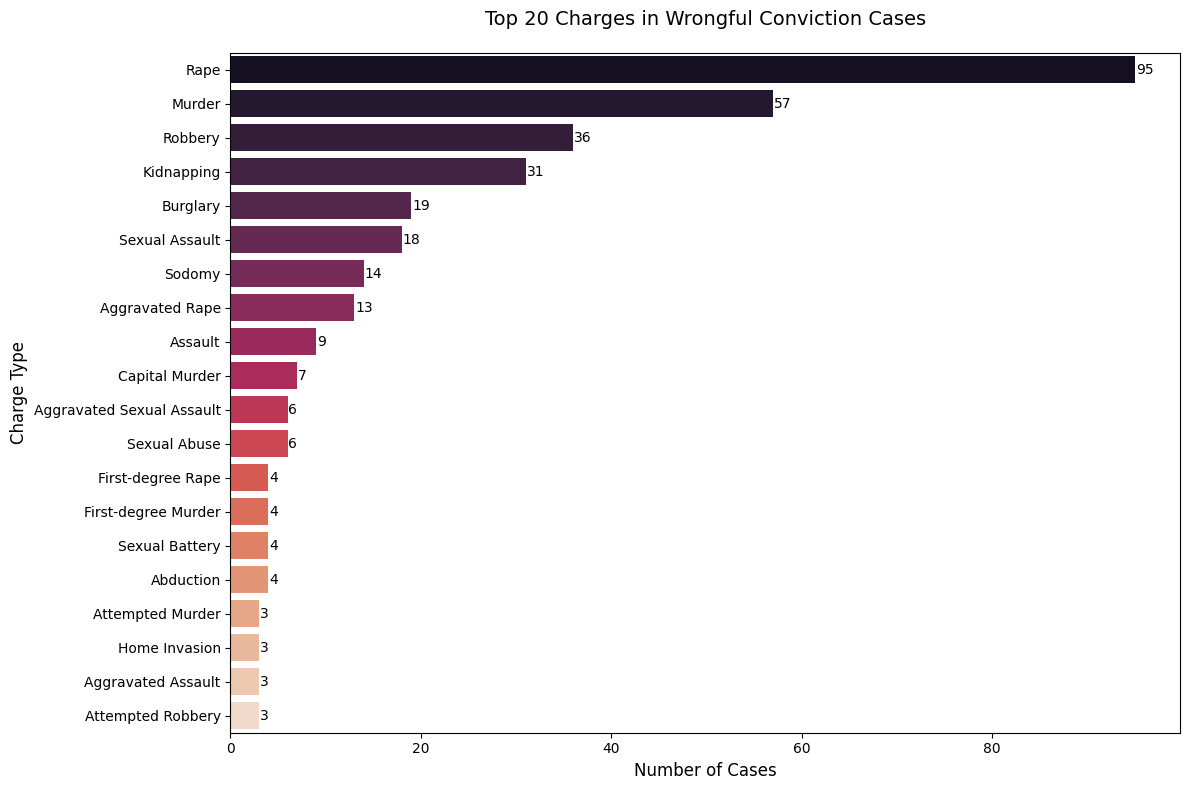

In [69]:
charge_columns = [
    'Abduction', 'Aggravated Assault', 'Aggravated Battery', 'Aggravated Burglary', 
    'Aggravated Criminal Sexual Assault', 'Aggravated Kidnapping', 'Aggravated Manslaughter (2 cts.)', 
    'Aggravated Rape', 'Aggravated Robbery', 'Aggravated Sexual Abuse', 
    'Aggravated Sexual Assault', 'Aggravated Sexual Assault (2 cts.)', 
    'Aggravated Sexual Assault of a Child', 'Armed Assault with Intent to Murder', 
    'Armed Criminal Action', 'Armed Robbery', 'Armed Robbery (2 cts.)', 'Assault', 
    'Assault and Battery', 'Assault and Battery by Means of a Dangerous Weapon', 
    'Assault and Battery on a Police Officer', 'Assault by Means of a Dangerous Weapon', 
    'Assault with Deadly Weapon', 'Assault with Intent', 'Assault with Intent to Rape', 
    'Attempted Aggravated Criminal Assault', 'Attempted Aggravated Murder', 
    'Attempted Aggravated Rape', 'Attempted Murder', 'Attempted Rape', 'Attempted Robbery', 
    'Attempted Sexual Battery', 'Attempted Sodomy', 'Battery', 'Burglary', 
    'Burglary 1 (2 cts.)', 'Burglary 2 (2 cts.)', 'Burglary of a Habitation', 
    'Capital Murder', 'Carrying Weapon', 'Child Abuse (2 cts.)', 'Child Molestation', 
    'Child Sex Abuse', 'Criminal Attempt', 'Criminal Conspiracy', 
    'Criminal Possession of Weapon', 'Criminal Sexual Assault', 'Criminal Sexual Contact', 
    'Daytime Burglary', 'Digital Penetration', 'Drug Possession', 
    'Entering Armed with Intent to Commit a Felony', 'False Imprisonment', 
    'Felonious Assault', 'Felonious Restraint', 'Felony Murder (2 cts.)', 'Felony murder', 
    'First-degree Burglary', 'First-degree Criminal Sexual Conduct', 'First-degree Murder', 
    'First-degree Rape', 'First-degree Robbery', 'First-degree Sexual Abuse', 
    'First-degree Sexual Assault', 'First-degree Sodomy', 
    'First-degree and Second-degree Robbery', 'Forced Oral Copulation', 
    'Forcible Oral Cop. (2 counts)', 'Forcible Rape', 'Forcible Rape (2 counts)', 
    'Forcible Sexual Intercourse', 'Forcible Sodomy', 'Forcible Unnatural Sexual Intercourse', 
    'Grand Larceny', 'Home Invasion', 'Indecency With a Child', 
    'Involuntary Deviate Sexual Intercourse', 'Kidnapping', 'Larceny', 'Murder', 
    'Oral Copulation', 'Perjury', 'Possession of Weapon', 'Possession of a Weapon', 'Rape', 
    'Rape (2 cts.', 'Rape (2 cts.)', 'Riot', 'Robbery', 'Robbery in the First Degree', 
    'Robbery with a Firearm', 'Second-degree Assault', 'Second-degree Homicide', 
    'Second-degree Murder', 'Second-degree Murder (4 counts)', 'Second-degree Sexual Assault', 
    'Sexual Abuse', 'Sexual Assault', 'Sexual Assault (2 cts.)', 
    'Sexual Assault (3 cts.)', 'Sexual Assault (7 cts.)', 'Sexual Assault of a Child', 
    'Sexual Battery', 'Sexual Intercourse Without Consent', 'Simple Assault', 
    'Simple Robbery', 'Sodomy', 'Stealing', 'Terroristic Threats', 'Unlawful Confinement', 
    'Unlawful Deviate Conduct', 'Unlawful Possession of a Weapon', 'Unlawful Restraint', 
    'Unlicensed Possession of a Firearm', 'Use of a Deadly Weapon', 'Use of a Firearm', 
    'Vehicle Theft'
]

top_20_charges = all_exon[charge_columns].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_charges.values, y=top_20_charges.index, palette='rocket')

plt.title('Top 20 Charges in Wrongful Conviction Cases', pad=20, fontsize=14)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Charge Type', fontsize=12)

for i, v in enumerate(top_20_charges.values):
    plt.text(v + 0.1, i, str(int(v)), va='center')

plt.tight_layout()
plt.show()

Murder and rape remain the most common cases, but there is a much broader variety of crime types among all exonerations compared to the narrower range seen in death penalty cases.

### All Death Sentences 

In [34]:
sentence_df = pd.read_csv("../../data/processed-data/sentences_cleaned.csv")
sentence_df.head()

,gender,races,jurisdiction,state_abbreviation,sub_jurisdiction,region,year,outcome_of_sentence,current_case_status,White,Black,Latino/a
0,Male,White,California,CA,Los Angeles County,West,1987.0,Active Death Sentence,Active Death Sentence,1,0,0
1,Male,White,California,CA,Los Angeles County,West,1979.0,Resentenced to Death,Active Death Sentence,1,0,0
2,Male,Black,California,CA,San Bernardino County,West,2006.0,Died on Death Row,Died on Death Row,0,1,0
3,Male,White,Florida,FL,Orange County,South,2008.0,Grant of Relief (Retrial/Resentencing Pending),Grant of Relief (Retrial/Resentencing Pending),1,0,0
4,Male,White,Texas,TX,Tom Green County,South,1988.0,Resentenced to Life or Less,Resentenced to Life or Less,1,0,0


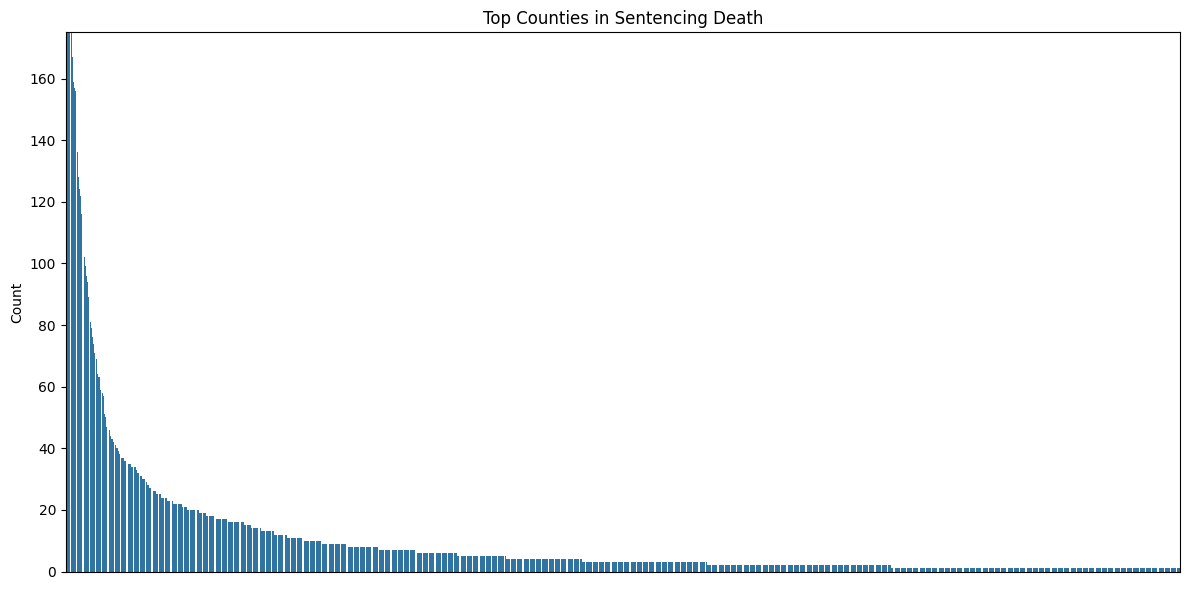

In [35]:
jurisdiction_counts = (
    sentence_df['sub_jurisdiction']
    .str.replace(' County', '', case=False)
    .value_counts()
)

plt.figure(figsize=(12, 6))
sns.barplot(y=jurisdiction_counts.values, x=jurisdiction_counts.index)
plt.title('Top Counties in Sentencing Death')
plt.ylabel('Count')

plt.gca().axes.get_xaxis().set_visible(False)
plt.ylim(0, 175)
plt.tight_layout()
plt.show()

This chart resembles an exponential curve, as the counts decrease rapidly at first and then taper off more gradually. This pattern is characteristic of exponential decay, where a small number of counties dominate the count, and the contribution diminishes significantly across the remaining counties.

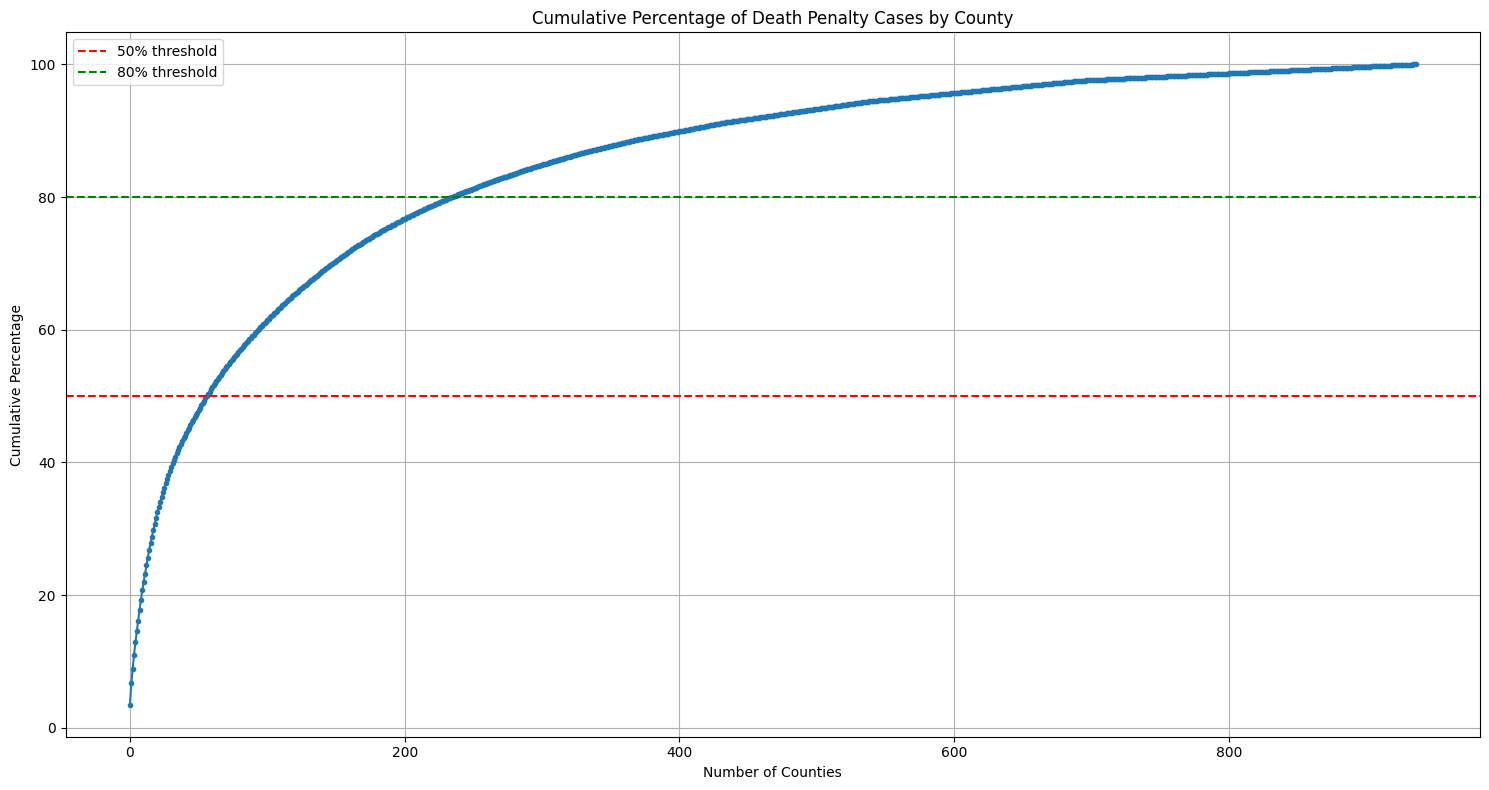

Number of counties for 50% of cases: 57
Number of counties for 80% of cases: 235
Total number of counties: 937


In [36]:
jurisdiction_df = pd.DataFrame(sentence_df['sub_jurisdiction'].str.replace(' County', '', case=False).value_counts()).reset_index()
jurisdiction_df.columns = ['jurisdiction', 'count']
jurisdiction_df['cumulative_percentage'] = 100 * jurisdiction_df['count'].cumsum() / jurisdiction_df['count'].sum()

plt.figure(figsize=(15, 8))
plt.plot(range(len(jurisdiction_df)), jurisdiction_df['cumulative_percentage'], marker='.')
plt.axhline(y=50, color='r', linestyle='--', label='50% threshold')
plt.axhline(y=80, color='g', linestyle='--', label='80% threshold')
plt.title('Cumulative Percentage of Death Penalty Cases by County')
plt.ylabel('Cumulative Percentage')
plt.xlabel('Number of Counties')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of counties for 50% of cases: {len(jurisdiction_df[jurisdiction_df['cumulative_percentage'] <= 50])}")
print(f"Number of counties for 80% of cases: {len(jurisdiction_df[jurisdiction_df['cumulative_percentage'] <= 80])}")
print(f"Total number of counties: {len(jurisdiction_df)}")

Out of 937 total counties, 57 counties (6% of total counties) account for 50% of cases and 235 counties (25% of total counties) account for 80% of cases. This shows a significant geographic concentration in how death penalties are applied. Let's look at this on a map of the United States.

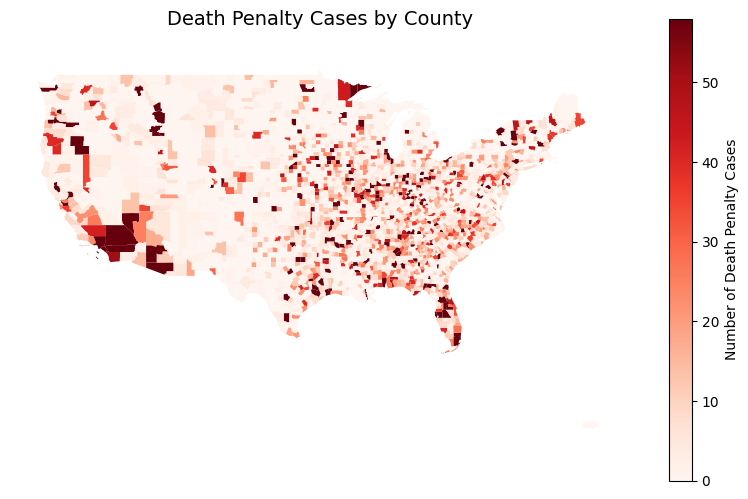

In [37]:
counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip')
counties = counties[~counties['STATEFP'].isin(['02', '15'])]

dp_counts = sentence_df['sub_jurisdiction'].str.replace(' County', '').value_counts().reset_index()
dp_counts.columns = ['County', 'Cases']
dp_counts['County'] = dp_counts['County'].str.upper()

counties['NAME'] = counties['NAME'].str.upper()
merged = counties.merge(dp_counts, left_on='NAME', right_on='County', how='left')
merged['Cases'] = merged['Cases'].fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))
merged.plot(column='Cases', 
           ax=ax,
           legend=True,
           legend_kwds={'label': 'Number of Death Penalty Cases'},
           missing_kwds={'color': 'lightgrey'},
           cmap='Reds',
           vmin=0,
           vmax=merged['Cases'].quantile(0.95))

plt.title('Death Penalty Cases by County', pad=20, size=14)
plt.axis('off')
plt.show()

One's likelihood of receiving a death sentence seems to be heavily influenced by county lines. This raises fundamental questions about equal justice and fairness in America's death penalty system. This is one important feature, let's see what else we can find.

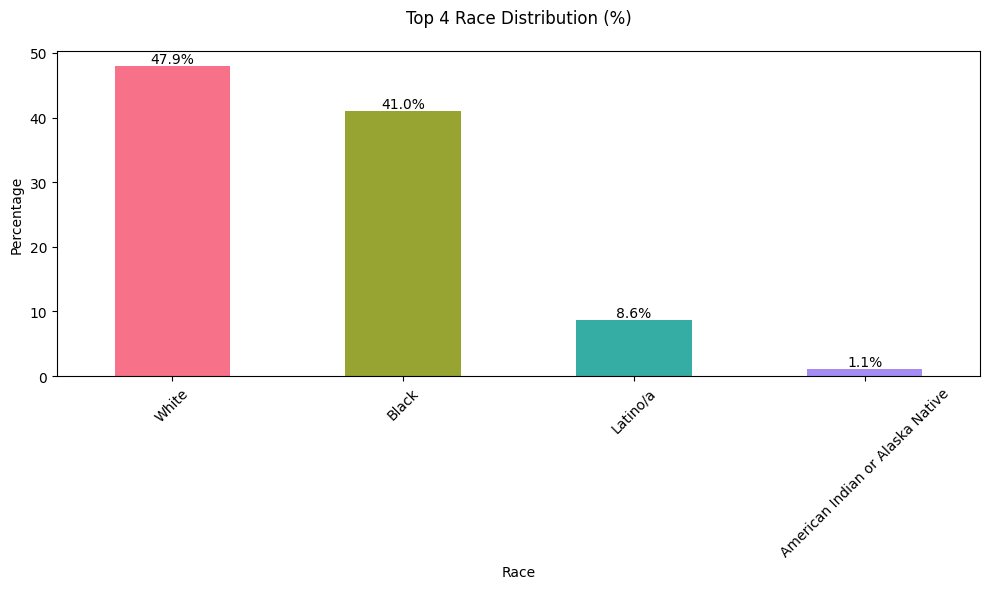

In [38]:
race_prop = sentence_df['races'].value_counts(normalize=True) * 100
top_race_prop = race_prop.head(4)  

plt.figure(figsize=(10, 6))
top_race_prop.plot(kind='bar', color=sns.color_palette("husl", len(top_race_prop)))
plt.title('Top 4 Race Distribution (%)', pad=20)
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

for i, v in enumerate(top_race_prop):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

White individuals are sentenced to death more frequently, though this may reflect the population demographics in the counties, making it important to consider the proportions of White and Black residents in these areas. We will begin by identifying the counties with the highest number of death sentences for White, Black, and Latino/a individuals, then compare these numbers to the racial demographics of those counties.

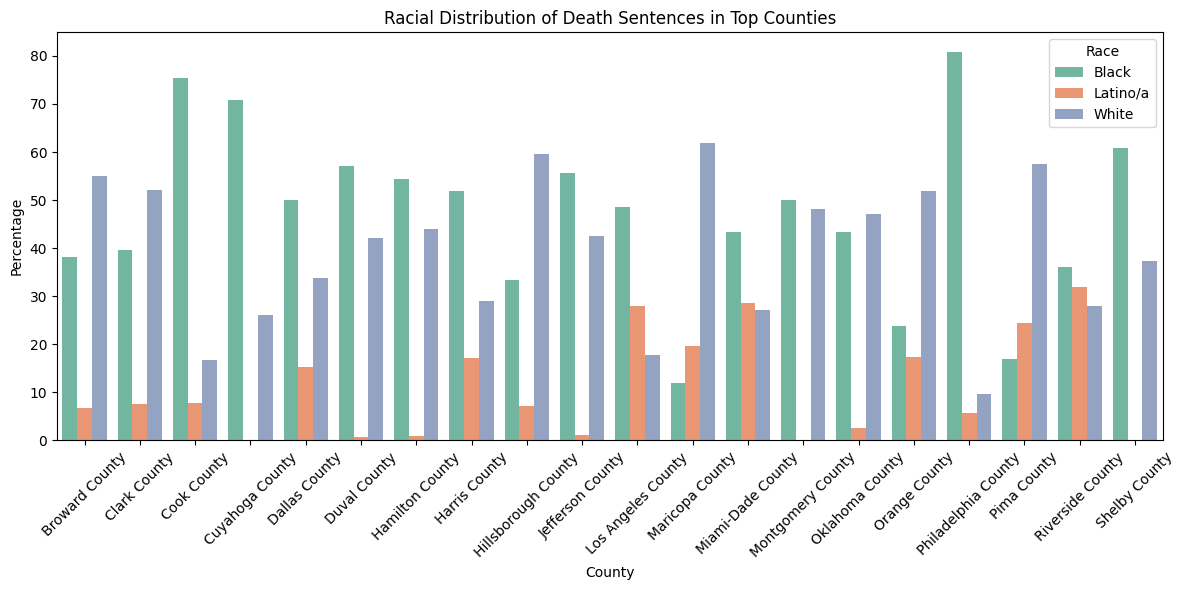

In [39]:
race_distribution = (
    sentence_df.groupby(['sub_jurisdiction', 'races'])
    .size()
    .reset_index(name='count')
)

race_distribution['total_count'] = race_distribution.groupby('sub_jurisdiction')['count'].transform('sum')
race_distribution['percentage'] = race_distribution['count'] / race_distribution['total_count'] * 100

top_counties = sentence_df['sub_jurisdiction'].value_counts().head(20).index
filtered_race_distribution = race_distribution[
    (race_distribution['sub_jurisdiction'].isin(top_counties)) & 
    (race_distribution['races'].isin(['White', 'Black', 'Latino/a']))
]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_race_distribution, 
    x='sub_jurisdiction', 
    y='percentage', 
    hue='races', 
    palette='Set2'
)
plt.title('Racial Distribution of Death Sentences in Top Counties')
plt.xlabel('County')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Race')
plt.tight_layout()
plt.show()


Black proportions are highest in Cook County, Dallas County, Duval County, Hamilton County, Harris County, Los Angeles County, Miami-Dade County, Montgomery County, Orange County, Riverside County. This is half of the top 20 counties.

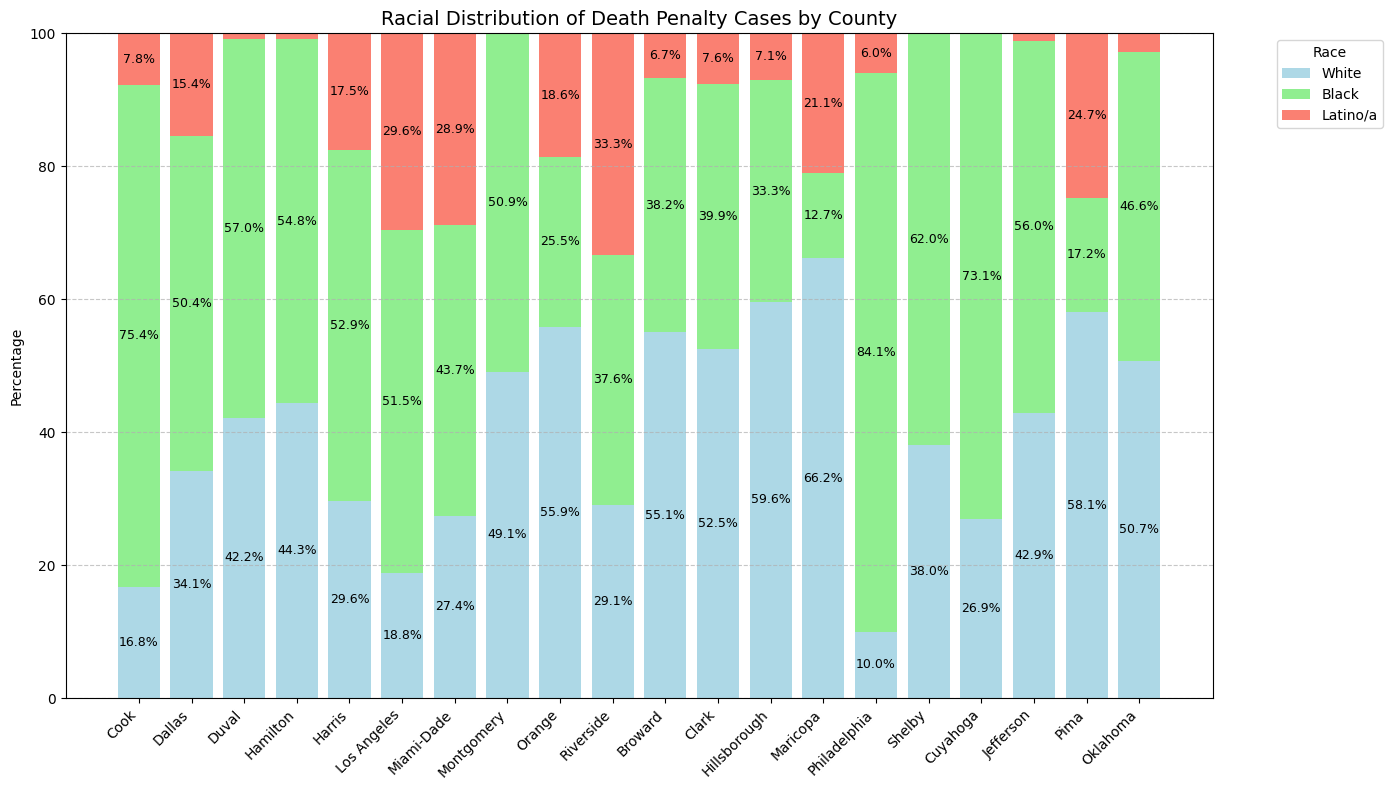

In [40]:
counties = [
    'Cook County', 
    'Dallas County', 
    'Duval County', 
    'Hamilton County', 
    'Harris County', 
    'Los Angeles County', 
    'Miami-Dade County', 
    'Montgomery County', 
    'Orange County', 
    'Riverside County',
    'Broward County', 
    'Clark County', 
    'Hillsborough County', 
    'Maricopa County', 
    'Philadelphia County', 
    'Shelby County', 
    'Cuyahoga County',
    'Jefferson County',
    'Pima County',
    'Oklahoma County'
]

plt.figure(figsize=(14, 8))

for i, county in enumerate(counties):
    county_data = sentence_df[sentence_df['sub_jurisdiction'] == county]
    race_counts = county_data['races'].value_counts()
    race_counts = race_counts.reindex(['White', 'Black', 'Latino/a'], fill_value=0)
    race_props = (race_counts / race_counts.sum()) * 100

    bottom = 0
    colors = ['lightblue', 'lightgreen', 'salmon']
    for j, (race, prop) in enumerate(race_props.items()):
        plt.bar(i, prop, bottom=bottom, label=race if i == 0 else "", color=colors[j])
        if prop > 5:  
            plt.text(i, bottom + prop / 2, f'{prop:.1f}%', ha='center', va='center', fontsize=9)
        bottom += prop

plt.xticks(range(len(counties)), [c.replace(' County', '') for c in counties], rotation=45, ha='right')
plt.ylabel('Percentage')
plt.title('Racial Distribution of Death Penalty Cases by County', fontsize=14)
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Let’s verify if this trend persists during more recent time, specifically 2009-2022.

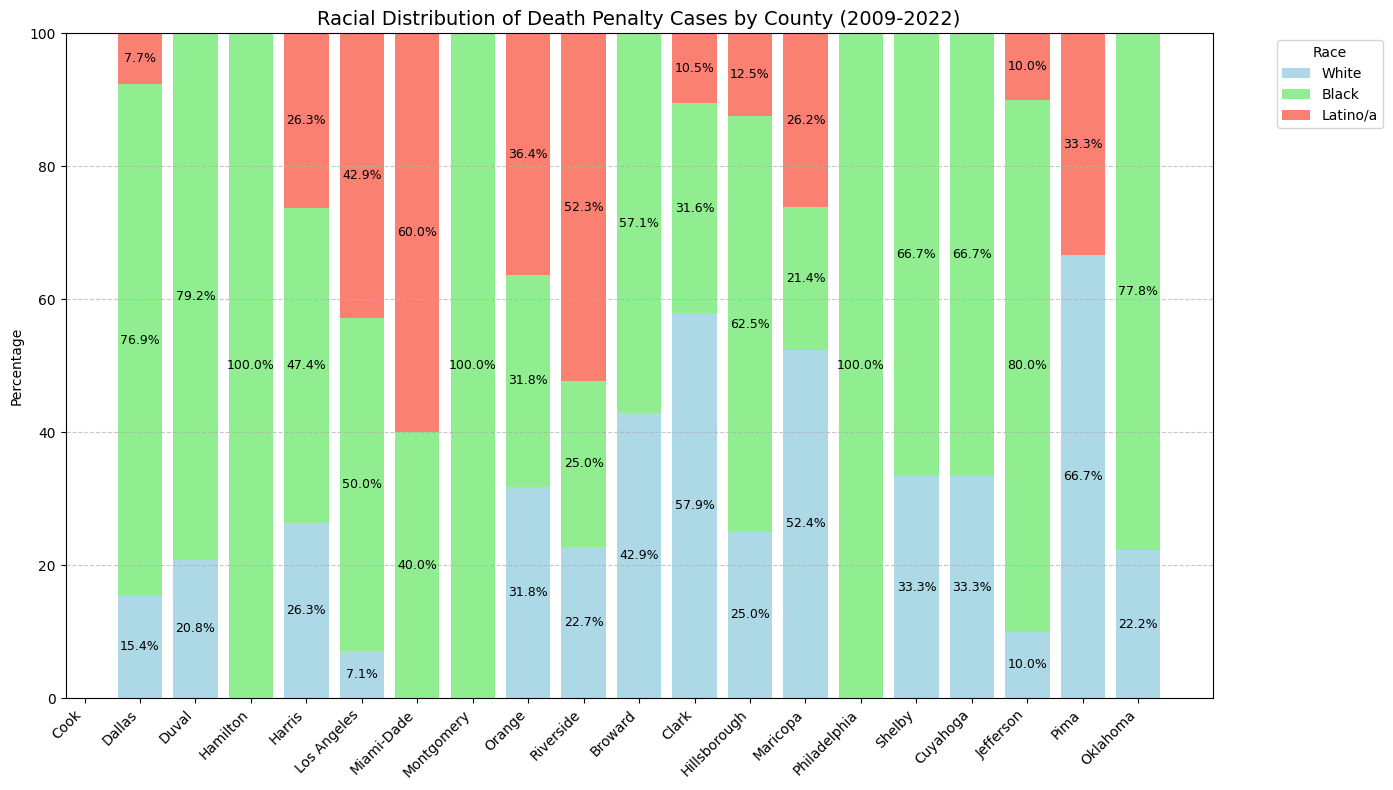

In [131]:
counties = [
    'Cook County', 
    'Dallas County', 
    'Duval County', 
    'Hamilton County', 
    'Harris County', 
    'Los Angeles County', 
    'Miami-Dade County', 
    'Montgomery County', 
    'Orange County', 
    'Riverside County',
    'Broward County', 
    'Clark County', 
    'Hillsborough County', 
    'Maricopa County', 
    'Philadelphia County', 
    'Shelby County', 
    'Cuyahoga County',
    'Jefferson County',
    'Pima County',
    'Oklahoma County'
]

filtered_data = sentence_df[(sentence_df['year'] >= 2009) & (sentence_df['year'] <= 2022)]

plt.figure(figsize=(14, 8))

for i, county in enumerate(counties):
    county_data = filtered_data[filtered_data['sub_jurisdiction'] == county]
    
    race_counts = county_data['races'].value_counts()
    race_counts = race_counts.reindex(['White', 'Black', 'Latino/a'], fill_value=0)
    
    race_props = (race_counts / race_counts.sum()) * 100

    bottom = 0
    colors = ['lightblue', 'lightgreen', 'salmon']
    for j, (race, prop) in enumerate(race_props.items()):
        plt.bar(i, prop, bottom=bottom, label=race if i == 0 else "", color=colors[j])
        if prop > 5: 
            plt.text(i, bottom + prop / 2, f'{prop:.1f}%', ha='center', va='center', fontsize=9)
        bottom += prop

plt.xticks(range(len(counties)), [c.replace(' County', '') for c in counties], rotation=45, ha='right')
plt.ylabel('Percentage')
plt.title('Racial Distribution of Death Penalty Cases by County (2009-2022)', fontsize=14)
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Black individuals continue to face disproportionate death sentences, even over the past 25 years. Next, we can compare these findings with population census data from the same time period.

In [123]:
import requests
from census import Census

c = Census("753f80f4494d3c8c5294d976d2b37fffcb71d895")

In [124]:
def get_county_demographics(year):
    county_fips = {
        'Dallas': ('48', '113'),         # Dallas County, TX
        'Duval': ('12', '031'),          # Duval County, FL
        'Hamilton': ('39', '061'),       # Hamilton County, OH 
        'Harris': ('48', '201'),         # Harris County, TX
        'Montgomery': ('42', '091'),      # Montgomery County, PA
        'Hillsborough': ('12', '057'),   # Hillsborough County, FL
        'Philadelphia': ('42', '101'),    # Philadelphia County, PA
        'Shelby': ('47', '157'),         # Shelby County, TN
        'Cuyahoga': ('39', '035'),       # Cuyahoga County, OH
        'Jefferson': ('01', '073'),       # Jefferson County, AL
        'Oklahoma': ('40', '109')         # Oklahoma County, OK
    }
    
    all_data = []
    for county, (state_fips, county_fips) in county_fips.items():
        try:
            data = c.acs5.state_county(
                ('NAME', 'B02001_002E', 'B02001_003E'),
                state_fips=state_fips,
                county_fips=county_fips,
                year=year
            )
            for d in data:
                d['year'] = year  
            all_data.extend(data)
        except Exception as e:
            print(f"Error getting data for {county}: {e}")
    
    return pd.DataFrame(all_data)

years = range(2009, 2022)
demographics = pd.concat([get_county_demographics(year) for year in years])

demographics = demographics.rename(columns={
    'B02001_002E': 'white_pop',
    'B02001_003E': 'black_pop',
})

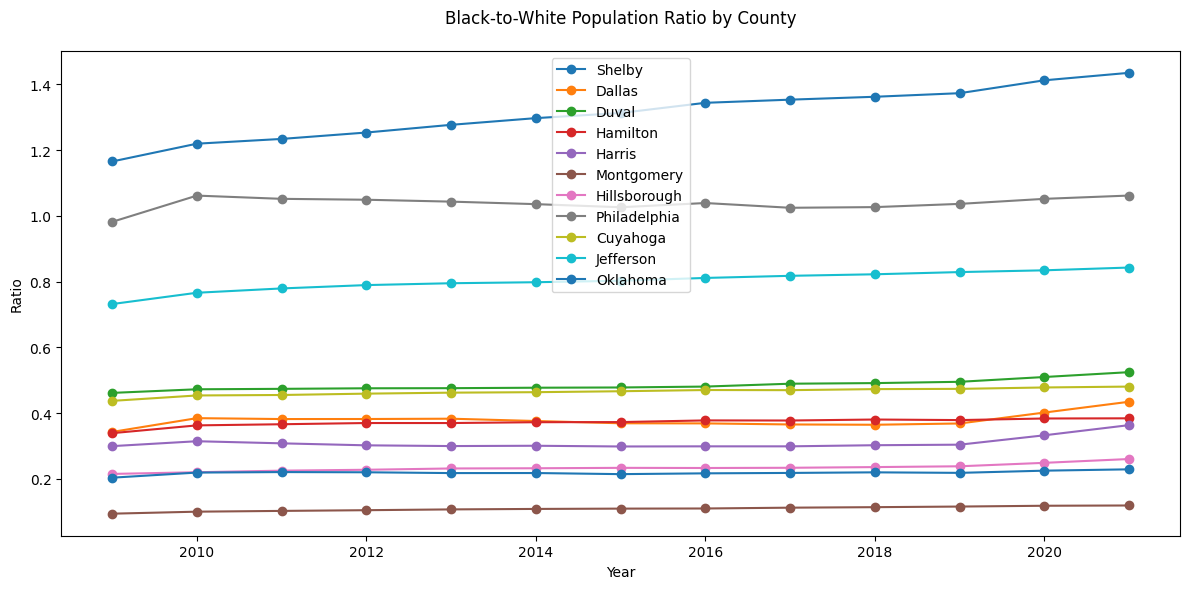

In [125]:
# Plot 1: Black-to-White Ratio
plt.figure(figsize=(12, 6))

for county in ['Shelby', 'Dallas', 'Duval', 'Hamilton', 'Harris', 
              'Montgomery', 'Hillsborough', 'Philadelphia', 'Cuyahoga', 
              'Jefferson', 'Oklahoma']:
   county_data = demographics[demographics['NAME'].str.contains(county, case=False)]
   plt.plot(county_data['year'], county_data['black_pop'] / county_data['white_pop'],
            label=county, marker='o')

plt.title('Black-to-White Population Ratio by County', pad=20)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

In [126]:
def get_county_demographics(year):
    county_fips = {
        'Los Angeles': ('06', '037'),
    }
    
    all_data = []
    for county, (state_fips, county_fips) in county_fips.items():
        try:
            data = c.acs5.state_county(
                ('NAME', 'B02001_002E', 'B02001_003E', 'B03003_003E'),
                state_fips=state_fips,
                county_fips=county_fips,
                year=year
            )
            for d in data:
                d['year'] = year  
            all_data.extend(data)
        except Exception as e:
            print(f"Error getting data for {county}: {e}")
    
    return pd.DataFrame(all_data)

years = range(2009, 2022)
demographics = pd.concat([get_county_demographics(year) for year in years])

demographics = demographics.rename(columns={
    'B02001_002E': 'white_pop',
    'B02001_003E': 'black_pop',
    'B03003_003E': 'hispanic_pop'
})

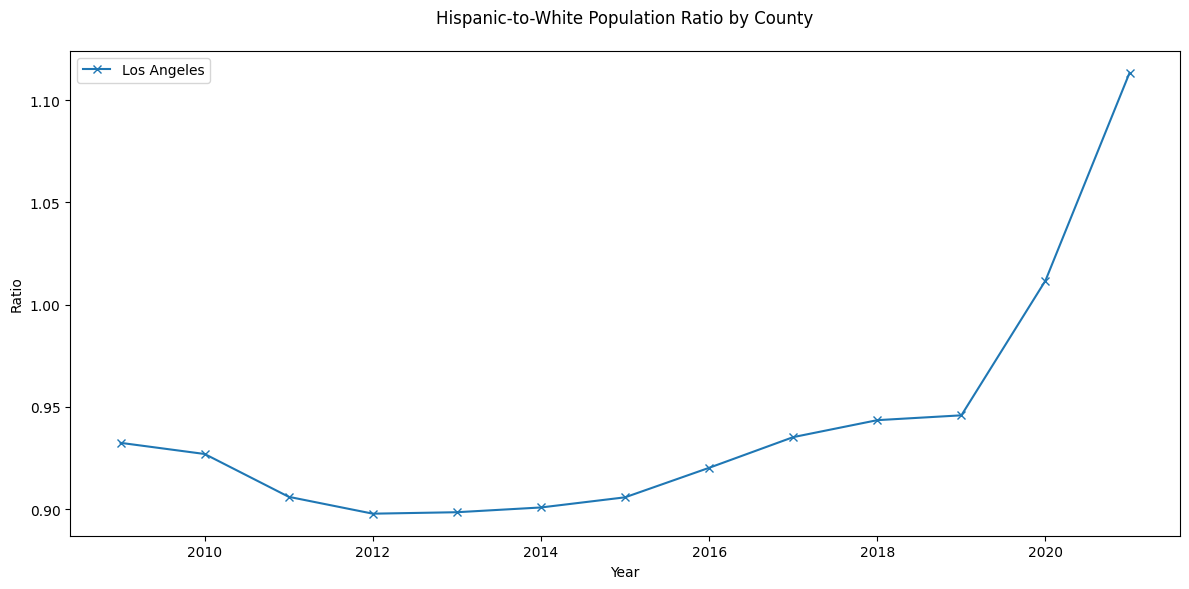

In [127]:
plt.figure(figsize=(12, 6))
for county in ['Los Angeles']:
    county_data = demographics[demographics['NAME'].str.contains(county, case=False)]
    plt.plot(county_data['year'], county_data['hispanic_pop'] / county_data['white_pop'], 
             label=county, marker='x')
plt.title('Hispanic-to-White Population Ratio by County', pad=20)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

Despite Hispanic residents comprising a smaller portion of the population compared to White residents until 2019, they consistently received death sentences at disproportionately higher rates during this period. This misalignment between population demographics and sentencing rates points to potential systemic disparities in how death sentences were applied across racial and ethnic groups. However, we do not have the crime data so we can not make a complete conclusion. 

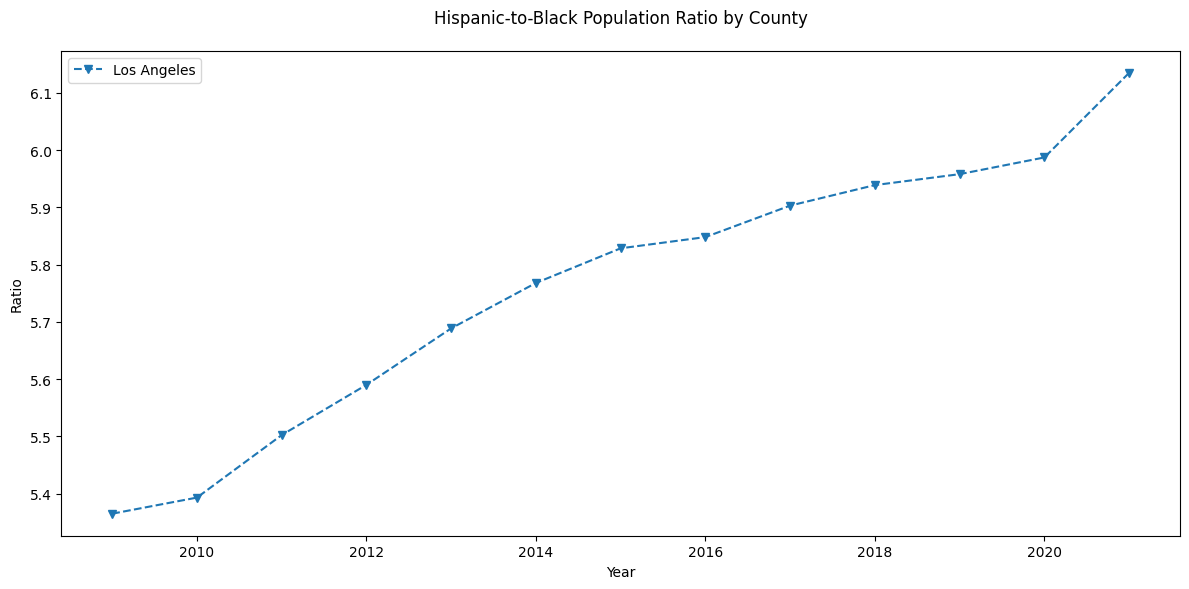

In [128]:
plt.figure(figsize=(12, 6))
for county in ['Los Angeles']:
    county_data = demographics[demographics['NAME'].str.contains(county, case=False)]
    plt.plot(county_data['year'], county_data['hispanic_pop'] / county_data['black_pop'], 
             label=county, linestyle='--', marker='v')
plt.title('Hispanic-to-Black Population Ratio by County', pad=20)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

Hispanic residents in Los Angeles County outnumber Black residents by a factor of five, this demographic ratio explains the higher death sentencing rates for Hispanic individuals, although we are still not comparing to crime data so there is some bias in the conclusion.

Conclusion: Black defendants are more likely to be sentenced to death in certain counties despite having a lower population and Latino/a sentences are heavily concentrated in a single county (Los Angeles).

Limitation: The Census data only tracks back to 2009, so we are going to assume that these trends have been relatively consistent since 1970. 

In [ ]:
counties = [
    'Cook County', 
    'Dallas County', 
    'Duval County', 
    'Hamilton County', 
    'Harris County', 
    'Los Angeles County', 
    'Miami-Dade County', 
    'Montgomery County', 
    'Orange County', 
    'Riverside County',
    'Broward County', 
    'Clark County', 
    'Hillsborough County', 
    'Maricopa County', 
    'Philadelphia County', 
    'Shelby County', 
    'Cuyahoga County',
    'Jefferson County',
    'Pima County',
    'Oklahoma County'
]

county_sentences = sentence_df[sentence_df['sub_jurisdiction'].isin(counties)]
county_sentences = county_sentences[county_sentences['races'].isin(['White', 'Black', 'Latino/a'])]

total_sentences = pd.crosstab(index=sentence_df['sub_jurisdiction'], 
                            columns=sentence_df['races'])[['White', 'Black', 'Latino/a']]
total_by_race = total_sentences.sum()

county_percentages = pd.crosstab(index=county_sentences['sub_jurisdiction'],
                               columns=county_sentences['races'])[['White', 'Black', 'Latino/a']]

county_pcts = county_percentages.div(total_by_race) * 100

print("Percentage of Total Death Sentences by Race for Each County:")
print("-" * 70)
print(county_pcts.round(2))

print("\nTotal Number of Death Sentences by Race:")
print(total_by_race)

Percentage of Total Death Sentences by Race for Each County:
----------------------------------------------------------------------
races                White  Black  Latino/a
sub_jurisdiction                           
Broward County        1.03   0.84      0.70
Clark County          1.75   1.55      1.41
Cook County           0.59   3.11      1.52
Cuyahoga County       0.53   1.68      0.00
Dallas County         0.88   1.53      2.22
Duval County          1.14   1.80      0.12
Hamilton County       1.07   1.55      0.12
Harris County         1.96   4.10      6.44
Hillsborough County   1.24   0.81      0.82
Jefferson County      1.64   2.52      0.23
Los Angeles County    1.29   4.12     11.24
Maricopa County       2.84   0.64      5.04
Miami-Dade County     0.78   1.46      4.57
Montgomery County     1.14   1.38      0.00
Oklahoma County       1.56   1.68      0.47
Orange County         1.71   0.91      3.16
Philadelphia County   0.42   4.17      1.41
Pima County           1.14   0.3



Hispanic individuals account for 11.2% of death penalty sentences in Los Angeles County, compared to only 2% for White individuals. 

Let's move on.

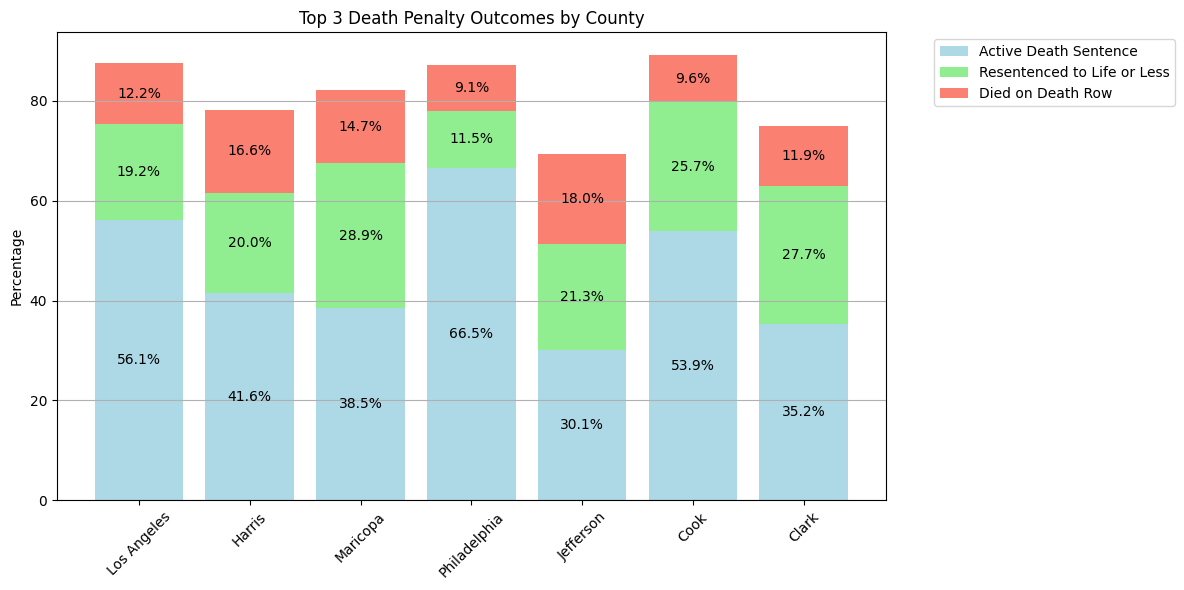

In [48]:
counties = ['Los Angeles County', 'Harris County', 'Maricopa County', 'Philadelphia County', 
           'Jefferson County', 'Cook County', 'Clark County']

plt.figure(figsize=(12, 6))

for i, county in enumerate(counties):
    county_data = sentence_df[sentence_df['sub_jurisdiction'] == county]
    outcome_props = county_data['outcome_of_sentence'].value_counts(normalize=True)
    outcome_props = outcome_props.head(3)  
    outcome_props = outcome_props * 100
    
    bottom = 0
    colors = ['lightblue', 'lightgreen', 'salmon']
    for j, (outcome, prop) in enumerate(outcome_props.items()):
        plt.bar(i, prop, bottom=bottom, label=outcome if i==0 else "", color=colors[j])
        if prop > 5:  
            plt.text(i, bottom + prop/2, f'{prop:.1f}%', ha='center', va='center')
        bottom += prop

plt.xticks(range(len(counties)), [c.replace(' County', '') for c in counties], rotation=45)
plt.ylabel('Percentage')
plt.title('Top 3 Death Penalty Outcomes by County')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

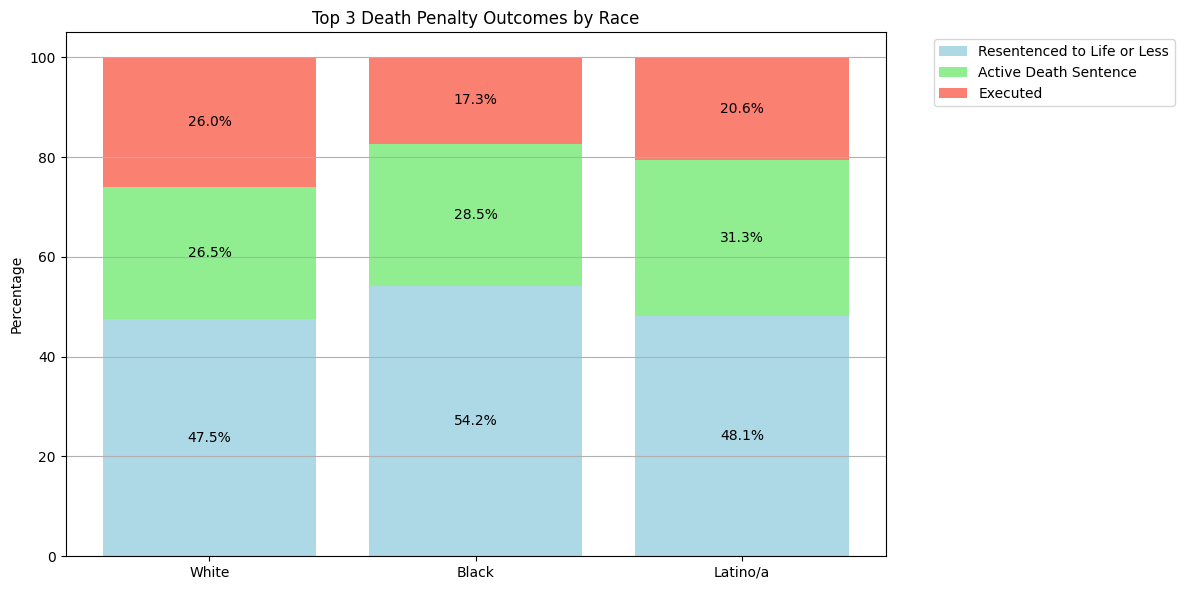

In [49]:
white_outcomes = sentence_df[sentence_df['races'] == 'White']['outcome_of_sentence'].value_counts().head(3)
black_outcomes = sentence_df[sentence_df['races'] == 'Black']['outcome_of_sentence'].value_counts().head(3)
latino_outcomes = sentence_df[sentence_df['races'] == 'Latino/a']['outcome_of_sentence'].value_counts().head(3)

plt.figure(figsize=(12, 6))

races = ['White', 'Black', 'Latino/a']
colors = ['lightblue', 'lightgreen', 'salmon']

for i, (outcomes, race) in enumerate(zip([white_outcomes, black_outcomes, latino_outcomes], races)):
    bottom = 0
    props = (outcomes / outcomes.sum() * 100).round(1)
    
    for j, (outcome, prop) in enumerate(props.items()):
        plt.bar(i, prop, bottom=bottom, label=outcome if i==0 else "", color=colors[j])
        if prop > 5:  
            plt.text(i, bottom + prop/2, f'{prop:.1f}%', ha='center', va='center')
        bottom += prop

plt.xticks(range(3), races)
plt.ylabel('Percentage')
plt.title('Top 3 Death Penalty Outcomes by Race')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

No signficant findings. lets look at sex

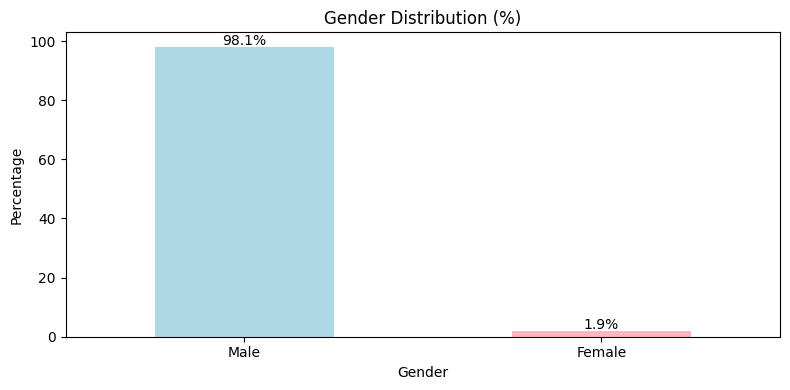

In [50]:
gender_prop = sentence_df['gender'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 4))
gender_prop.plot(kind='bar', color=['lightblue', 'lightpink'])
plt.title('Gender Distribution (%)')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

for i, v in enumerate(gender_prop):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

The vast majority of individuals sentenced to death are male. Lastly, let's look at year. 

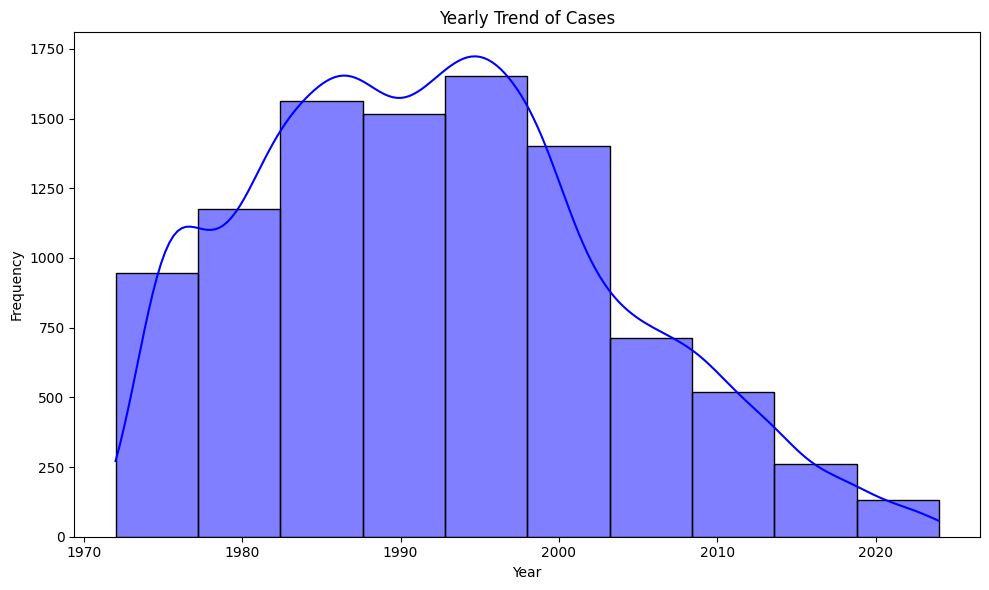

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sentence_df, x='year', kde=True, bins=10, color='blue')
plt.title('Yearly Trend of Cases')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Cases have declined significantly in recent years, indicating that the year of the case plays a significant role in the likelihood of receiving the death penalty.

### Victims

In [54]:
victims_df = pd.read_csv("../../data/raw-data/all_executions.csv")

male_victim_columns = [
    'Number of White Male Victims', 
    'Number of Black Male Victims', 
    'Number of Latino/a Male Victims', 
]

female_victim_columns = [
    'Number of White Female Victims', 
    'Number of Black Female Victims', 
    'Number of Latino/a Female Victims', 
]

male_victims_counts = {col.replace('Number of ', '').replace(' Victims', ''): victims_df[col].sum() for col in male_victim_columns}
female_victims_counts = {col.replace('Number of ', '').replace(' Victims', ''): victims_df[col].sum() for col in female_victim_columns}

print("Victim Counts by Gender and Race:\n")

print("Male Victims:")
for race, count in male_victims_counts.items():
    print(f"  {race}: {count}")

print("\nFemale Victims:")
for race, count in female_victims_counts.items():
    print(f"  {race}: {count}")


Victim Counts by Gender and Race:

Male Victims:
  White Male: 862
  Black Male: 183
  Latino/a Male: 104

Female Victims:
  White Female: 873
  Black Female: 175
  Latino/a Female: 59


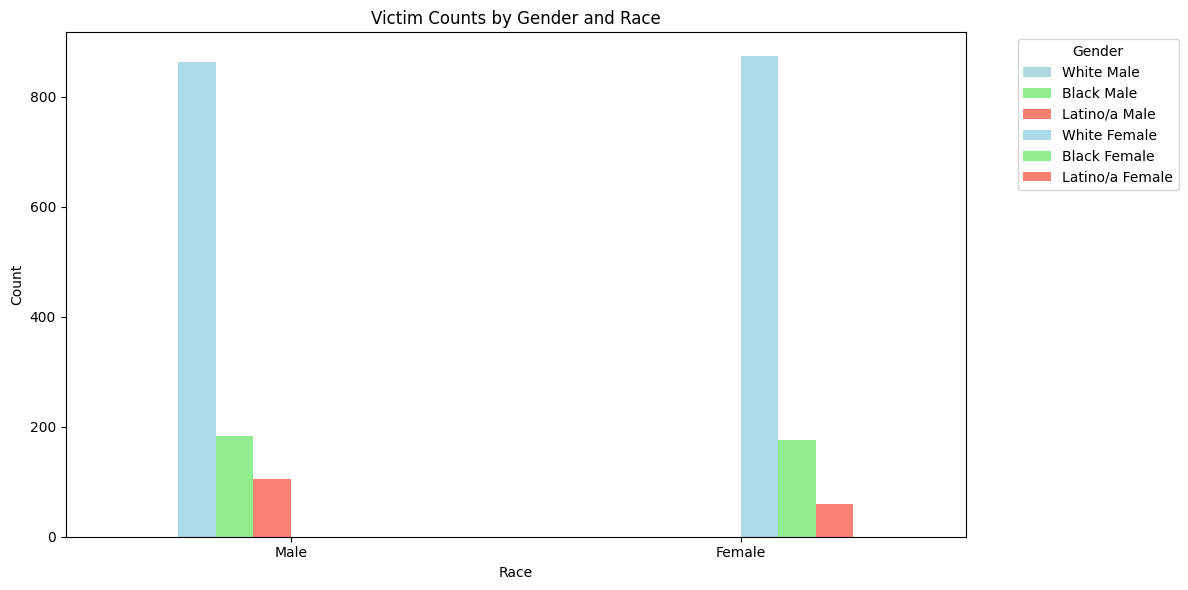

In [55]:
plot_data = pd.DataFrame({
    'Male': male_victims_counts,
    'Female': female_victims_counts
}).T

plot_data.plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Victim Counts by Gender and Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Summary

## Overview
Through exploratory data analysis, I examined several key aspects of the death penalty in the United States, including geographic distribution, racial patterns, victim characteristics, and trends over time. 

## Key Findings

### Geographic Distribution
- 27 states currently have the death penalty, while 23 have abolished it. 
- Death penalty abolition occurred in distinct waves, with early adopters like Michigan and Wisconsin in the 1800s, followed by more recent abolitions since 2000
- Significant geographic concentration in death penalty cases:
 - 57 counties (6% of total) account for 50% of cases
 - 235 counties (25% of total) account for 80% of cases

### Racial Patterns  
- Black defendants receive disproportionately high death sentences in certain jurisdictions compared to their population size
- Hispanic defendants show a high concentration in Los Angeles County
- White defendants represent the highest total number of death sentences, but are more spread out across counties

### Victim Characteristics
- Similar numbers of White male (862) and White female (873) victims
- Lower numbers for other racial groups: Black male (183), Black female (175), Hispanic male (104), Hispanic female (59)
- Clear disparities in how cases with victims of different races are prosecuted

### Temporal Trends
- Significant decline in death sentences in recent years
- Oklahoma currently has the highest number of scheduled executions
- Future executions are concentrated in specific states

## Limitations
- Census data only available from 2009 onwards
- Crime data not available for complete demographic comparison
- Cannot establish direct causation for observed disparities

This analysis highlights significant geographic and racial disparities in how the death penalty is applied, while also showing a general decline in its use over time. The concentration of cases in specific jurisdictions raises important questions about equal justice under the law.